<a href="https://colab.research.google.com/github/Walt9819/factores-impacto-desempleo-mexico/blob/main/AD_Python/restaurantes_cdmx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recuperación económica post-COVID: Localización óptima de restaurantes en México**

# **Módulo 4:  Análisis de datos con Python**

## **Conjuntos de datos**
La información explorada para este proyecto y módulo esta conformada por:
*   Encuesta intercensal 2015 INEGI
*   Censos económicos 2019 INEGI
*   Encuesta Nacional de Ocupación y Empleo (ENOE) Cuarto cuatrimestre del 2020 [obtención de datos](https://colab.research.google.com/drive/11LSX5D_t9gTVXX0hJzpuUMjNIPyJiy9n?usp=sharing)
*   Directorio Estadístico Nacional de Unidades Económicas (DENUE)
*   Marco Geoestadístico 2019 - 2020 INEGI


## **Instalación e importación de módulos**

In [63]:
!pip install geopandas
!pip install pandas_bokeh

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import geopandas

import locale
from datetime import datetime
import plotly.express as px
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import dateutil

import pandas_bokeh
pandas_bokeh.output_notebook()

## **Integración de los conjuntos de datos**

Lectura de archivo CSV con datos referentes al número de restaurantes por municipio. Fuente: **DENUE**




In [65]:
denue = pd.read_csv(r"https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/AD_Python/data/denue_final.csv", sep = ';')
denue

Unnamed: 0  ...  Restaurantes que preparan otro tipo de alimentos para llevar
0              0  ...                                                7.0           
1              1  ...                                                0.0           
2              2  ...                                                0.0           
3              3  ...                                                8.0           
4              4  ...                                              197.0           
...          ...  ...                                                ...           
2401        2401  ...                                              364.0           
2402        2402  ...                                              367.0           
2403        2403  ...                                              945.0           
2404        2404  ...                                              420.0           
2405        2405  ...                                              611.0           

[2406 rows x 9 columns]

In [66]:
# Se cambian los nombres de las columnas
denue.columns = ['idx', 'imun',
       'comida_carta_corrida',
       'antojitos',
       'pescados_mariscos',
       'pizzas_hamburguesas_hotdogs_pollos_rostizados',
       'tacos_tortas',
       'autoservicio',
       'otro_tipo_alimentos']

Lectura de los indicadores socioeconómicos por municipio. Fuente: **ENOE**

In [67]:
indicadores_socioeconomicos = pd.read_csv(r"https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/AD_Python/data/indicadores_socioeconomicos.csv")
indicadores_socioeconomicos

id_ent_mun              municipio  ...  pob_60_64  pob_65_more
0           1001         Aguascalientes  ...      35638        65188
1           1002               Asientos  ...       1481         3820
2           1003               Calvillo  ...       2455         5998
3           1004                  Cosío  ...        531         1271
4           1005            Jesús María  ...       3361         6214
...          ...                    ...  ...        ...          ...
2452       32054          Villa Hidalgo  ...        635         1460
2453       32055             Villanueva  ...       1482         3968
2454       32056              Zacatecas  ...       6230         9813
2455       32057               Trancoso  ...        516         1095
2456       32058  Santa María de la Paz  ...        133          417

[2457 rows x 22 columns]

In [68]:
# Se cambian los nombres de las columnas
indicadores_socioeconomicos.columns = ['imun', 'municipio', 'ing_lab', 'ocupados', 'desocupados', 'pob',
       'pob_muj', 'pob_hom', 'pob_0_4', 'pob_5_9', 'pob_10_14', 'pob_15_19',
       'pob_20_24', 'pob_25_29', 'pob_30_34', 'pob_35_39', 'pob_40_44',
       'pob_45_49', 'pob_50_54', 'pob_55_59', 'pob_60_64', 'pob_65_more']

Lectura de los indicadores sociodemográficos por municipio. Fuente: **INEGI**



In [69]:
dataframe = pd.read_csv(r"https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/AD_Python/data/Indicadores_INEGI_covid19.csv", encoding = 'ISO-8859-1')
dataframe

imun  ent  ... tot_p_m_n_e_a  tot_p_m_n_e_p
0         0    0  ...       8031296          51.66
1      1000    1  ...        113657          54.84
2      1001    1  ...         75821          53.48
3      1002    1  ...           788          43.42
4      1003    1  ...          3777          49.78
...     ...  ...  ...           ...            ...
2491  32054   32  ...           230          42.51
2492  32055   32  ...          1384          35.32
2493  32056   32  ...         18294          48.95
2494  32057   32  ...           463          46.07
2495  32058   32  ...            77          30.80

[2496 rows x 148 columns]

Integración de los datos provientes de diferentes fuentes de información, se realizó el merge a la izquierda por el identificador municipal.



In [70]:
dataframe = dataframe.merge(denue, on='imun', how='left')

In [71]:
dataframe = dataframe.merge(indicadores_socioeconomicos, on = 'imun', how = 'left')

Lectura de los objetos espaciales vectoriales de cada municipio a nivel nacional en formato SHP. Fuente: **Marco Geoestadístico 2019 - 2020**



In [72]:
mun_geo = geopandas.read_file("https://github.com/Walt9819/factores-impacto-desempleo-mexico/blob/main/AD_Python/data/mun2019gw.zip?raw=true")

In [73]:
mun_geo

CVEGEO  ...                                           geometry
0     01001  ...  POLYGON ((-102.10641 22.06035, -102.10368 22.0...
1     01002  ...  POLYGON ((-102.05189 22.29144, -102.05121 22.2...
2     01003  ...  POLYGON ((-102.68569 22.09963, -102.69087 22.0...
3     01004  ...  POLYGON ((-102.28787 22.41649, -102.28753 22.4...
4     01005  ...  POLYGON ((-102.33568 22.05067, -102.33348 22.0...
...     ...  ...                                                ...
2460  32054  ...  POLYGON ((-101.69490 22.51777, -101.69472 22.5...
2461  32055  ...  POLYGON ((-102.78252 22.67373, -102.78221 22.6...
2462  32056  ...  POLYGON ((-102.76690 22.84147, -102.76619 22.8...
2463  32057  ...  POLYGON ((-102.22547 22.80920, -102.22946 22.7...
2464  32058  ...  POLYGON ((-103.38994 21.57379, -103.38332 21.5...

[2465 rows x 10 columns]

## **Limpieza y validación de datos**

Número de registros en el conjunto de datos INEGI

In [74]:
dataframe.shape

(2496, 177)

Esta información cuenta con los totales nacionales y estatales, los cuales no son requeridos para nuestro análisis. Por lo tanto, se omiten con las siguientes líneas de código.

In [75]:
# Se omiten las filas que contengan 0 en el atributo *mun* (representa el identificador del municipio)
# Aplica para los totales estatales
mask = (dataframe.mun != 0)
dataframe = dataframe.loc[mask]
dataframe.shape

(2464, 177)

In [76]:
# De la misma manera, se omiten aquellas filas con NA en el mismo atributo *mun* 
# Aplica para el total nacional
dataframe = dataframe[dataframe['mun'].notna()]
dataframe.shape

(2463, 177)

En este paso, se acota el conjunto de atributos a utilizar en nuestro proyecto. A continuación, se listan los nombres:

*   Clave geográfica
*   Clave de la entidad
*   Nombre de la entidad
*   Clave del municipio
*   Nombre del municipio
*   Población total
*   Ingreso laboral
*   Personas ocupadas
*   Personas desocupadas
*   Población que trabaja en la misma entidad pero en un municipio distinto al de residencia
*   Total de establecimientos
*   Número de establecimientos esenciales
*   Número de establecimientos no esenciales
*   Personas ocupadas en los establecimientos
*   Personas ocupadas en los establecimientos esenciales
*   Personas ocupadas en los establecimientos no esenciales
* Los columnas restantes representan el número de establecimientos por nombre del código de actividad conforme al SCIAN 2018.



In [77]:
dataframe = dataframe[['imun','ent','nom_ent','mun','nom_mun','pobtot','ing_lab', 'ocupados', 'desocupados', 'pob','pea','ocupada',
                       'tra_omun','tot_est','est_e_a','est_n_e_a',
                       'tot_p_o','po_e_a','po_n_e_a','comida_carta_corrida',
                       'antojitos','pescados_mariscos','pizzas_hamburguesas_hotdogs_pollos_rostizados',
                       'tacos_tortas','autoservicio','otro_tipo_alimentos']]

Algunos de los valores númericos considerados en el estudio presentaron valores NA, los cuales para evitar ser descartados en su totalidad, se rellenaron con 0.

In [78]:
dataframe = dataframe.fillna(0)

Al igual, varios municipios nuevos en el marco geográfico presentaban valores negativos, los cuales también fueron reemplazados por 0.

In [79]:
dataframe.pea[dataframe.pea.lt(0)] = 0
dataframe.ocupada[dataframe.ocupada.lt(0)] = 0
dataframe.tra_omun[dataframe.tra_omun.lt(0)] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Para fines de la integración entre los datos geoespaciales y los atributos númericos, se concatenó un atributo del tipo caracter con nombre **CVEGEO** entre la clave de la entidad y del municipio.

In [80]:
dataframe['CVEGEO'] = dataframe['imun'].apply(lambda x: str(x).zfill(5))
dataframe

imun  ent         nom_ent  ...  autoservicio otro_tipo_alimentos  CVEGEO
2      1001    1  Aguascalientes  ...          96.0               338.0   01001
3      1002    1  Aguascalientes  ...           0.0                 5.0   01002
4      1003    1  Aguascalientes  ...           2.0                 4.0   01003
5      1004    1  Aguascalientes  ...           0.0                 2.0   01004
6      1005    1  Aguascalientes  ...           3.0                28.0   01005
...     ...  ...             ...  ...           ...                 ...     ...
2491  32054   32       Zacatecas  ...           0.0                 0.0   32054
2492  32055   32       Zacatecas  ...           2.0                 3.0   32055
2493  32056   32       Zacatecas  ...          32.0                44.0   32056
2494  32057   32       Zacatecas  ...           0.0                 0.0   32057
2495  32058   32       Zacatecas  ...           1.0                 0.0   32058

[2463 rows x 27 columns]

## **Postwork 1. Estimados de localización y variabilidad**

Vamos a usar estimados de locación y variabilidad para describir nuestro dataset. Ya tenemos un dataset limpio, así que ahora toca extraer información útil de él.

Recuerda que sólo es posible obtener estimados de locación y variabilidad cuando tenemos datos numéricos (tanto discretos como continuos).

La actividad consiste en lo siguiente:

1. Identifica las columnas de tu dataset que tengan datos numéricos.
2. Identifica la relevancia de esas columnas (qué tan importantes son para responder a tus preguntas).
3. Obtén los siguientes estimados de tus columnas numéricas:
    
    a. Promedio 

    b. Mediana 

    c. Media Truncada 

    d. Desviación estándar 

    e. Rango 

    f. Percentiles 25 y 75 (por lo menos) 

    g. Rango intercuartil

### 1. Identifica las columnas de tu dataset que tengan datos numéricos.

Todas las variables son numéricas, excepto CVEGEO y aquellas que contienen los nombres de las entidades federativas y los municipios.

In [81]:
dataframe

imun  ent         nom_ent  ...  autoservicio otro_tipo_alimentos  CVEGEO
2      1001    1  Aguascalientes  ...          96.0               338.0   01001
3      1002    1  Aguascalientes  ...           0.0                 5.0   01002
4      1003    1  Aguascalientes  ...           2.0                 4.0   01003
5      1004    1  Aguascalientes  ...           0.0                 2.0   01004
6      1005    1  Aguascalientes  ...           3.0                28.0   01005
...     ...  ...             ...  ...           ...                 ...     ...
2491  32054   32       Zacatecas  ...           0.0                 0.0   32054
2492  32055   32       Zacatecas  ...           2.0                 3.0   32055
2493  32056   32       Zacatecas  ...          32.0                44.0   32056
2494  32057   32       Zacatecas  ...           0.0                 0.0   32057
2495  32058   32       Zacatecas  ...           1.0                 0.0   32058

[2463 rows x 27 columns]

In [82]:
dataframe.dtypes

imun                                               int64
ent                                                int64
nom_ent                                           object
mun                                              float64
nom_mun                                           object
pobtot                                           float64
ing_lab                                          float64
ocupados                                         float64
desocupados                                      float64
pob                                              float64
pea                                              float64
ocupada                                          float64
tra_omun                                         float64
tot_est                                            int64
est_e_a                                            int64
est_n_e_a                                          int64
tot_p_o                                            int64
po_e_a                         

### 2. Identifica la relevancia de esas columnas (qué tan importantes son para responder a tus preguntas).

* ***imun***: Permite identificar los registros por cada entidad y municipio.
* ***variables sobre tipos de restautantes***: muestran el número de restaurantes por cada categoría.
* ***variables de población***: permiten relacionar a la población total y por concidión de ocupación. 
* ***ing_lab***: esta variable se refiere al ingreso laboral promedio de la población ocupada en alguna actividad económica, si bien existen municipios sin estos datos (por el alcance que la ENOE ha tenido durante la pandemia), es importante tener dicha variable si se requiere saber la disponibilidad a pagar de las personas.

### 3. Obtén los siguientes estimados de tus columnas numéricas: a) Promedio b) Mediana c) Media Truncada d) Desviación estándar e) Rango f) Percentiles 25 y 75 (por lo menos) g) Rango intercuartil

In [83]:
df = dataframe.drop(['imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO'], axis=1)

In [84]:
def generarEstadisticos(df):
  estadisticos  = pd.DataFrame()
  estadisticos['promedio'] = df.mean()
  estadisticos['desviación estándar'] = df.std()
  estadisticos['mínimo'] = df.min()
  estadisticos['cuantil 10'] = df.quantile(0.1)
  estadisticos['cuantil 25'] = df.quantile(0.25)
  estadisticos['mediana'] = df.median()
  estadisticos['cuantil 75'] = df.quantile(0.75)
  estadisticos['cuantil 90'] = df.quantile(0.9)
  estadisticos['máximo'] = df.max()
  estadisticos['rango intercuartílico'] = estadisticos['cuantil 75'] - estadisticos['cuantil 25']
  return estadisticos

def distributionSkewAndKurtosis(df):
  est = pd.DataFrame()
  est["skew"] = df.skew()
  est["kurtosis"] = df.kurtosis()
  return est

In [85]:
estadisticos = generarEstadisticos(df).round(decimals=2)
estadisticos

promedio  ...  rango intercuartílico
pobtot                                         48530.55  ...               30098.50
ing_lab                                         2025.39  ...                4363.84
ocupados                                       18897.76  ...               15079.50
desocupados                                     1358.05  ...                   0.00
pob                                            52363.96  ...               32916.50
pea                                            19079.37  ...                9844.00
ocupada                                        18305.08  ...                9495.50
tra_omun                                        2710.38  ...                1146.00
tot_est                                         2545.38  ...                1852.50
est_e_a                                         1372.76  ...                1022.50
est_n_e_a                                       1172.62  ...                 851.00
tot_p_o                                        14390.39  ...                6261.00
po_e_a                                          6976.96  ...                3210.00
po_n_e_a                                        7413.43  ...                2961.00
comida_carta_corrida                              26.55  ...                  12.00
antojitos                                         56.25  ...                  36.00
pescados_mariscos                                  9.91  ...                   5.00
pizzas_hamburguesas_hotdogs_pollos_rostizados     27.67  ...                  17.00
tacos_tortas                                      54.97  ...                  31.00
autoservicio                                       4.04  ...                   1.00
otro_tipo_alimentos                               25.43  ...                  12.00

[21 rows x 10 columns]

Se observan muchos valores en cero, especialmente en la variable de ingreso laboral, ocupados y desocupados, así como en varias categorías de restaurantes. No se eliminarán los renglones que contienen esos valores, sin embargo es posible que en análisis posteriores se omitan por ser datos atípicos o sin sentido.


## **2. Introducción a la visualización de datos: Distribuciones**

En este Postwork vamos a explorar las distribuciones de las variables numéricas que tengamos en nuestro dataset.

Realiza los siguientes procesos en los casos en los que tenga sentido aplicarlos:

1. Utiliza boxplots para analizar la distribución de tus variables numéricas. Piensa acerca de cuáles son los valores típicos y atípicos y dónde están concentrados el grueso de tus datos.
2. Utiliza el Score de Rango Intercuartílico para filtrar tus valores atípicos. Compara tus medianas, medias y desviaciones estándares antes y después de realizar la filtración y ve cuánto cambiaron.
3. Utiliza tablas de frecuencia e histogramas para observar la distribución de tus variables. Caracteriza cada una de las distribuciones usando los términos que aprendiste durante la sesión. Obtén medidas de asimetría y curtosis para ver qué tan alejadas de la distribución normal están tus variables.
4. Utiliza gráficas de densidad para comparar una variable numérica que pueda ser segmentada en dos o más categorías. Usa esta técnica para entender mejor cómo están distribuidos tus datos en cada uno de los grupos presentes.

### Análisis de población y empleabilidad

In [86]:
pobData = dataframe.loc[:, "ing_lab":"po_n_e_a"]
pobData.head(5)
pobTypes = pobData.columns

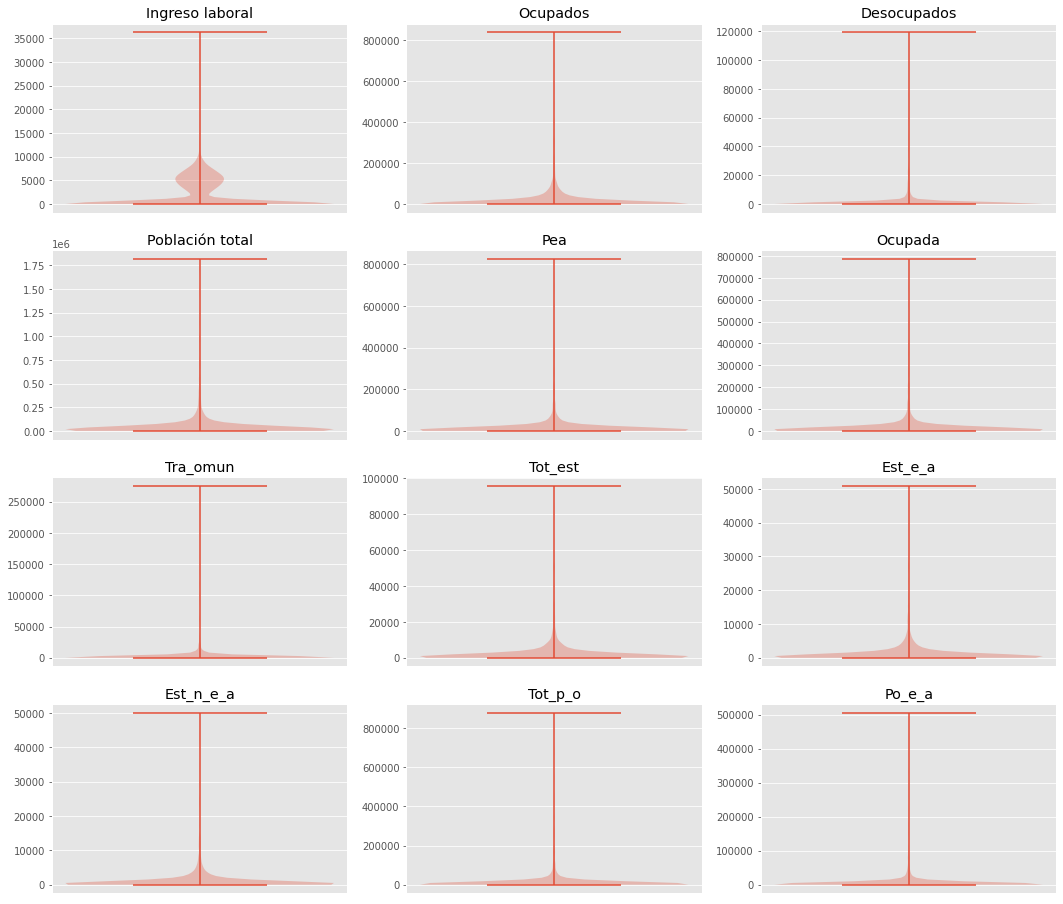

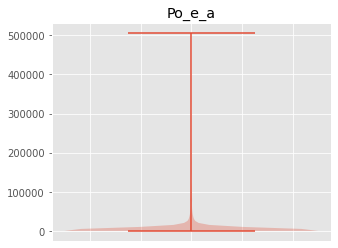

In [87]:
pobCols = {"ing_lab": "Ingreso laboral", "pob": "Población total"}
pobKeys = pobCols.keys()
fig, axs = plt.subplots(4, 3, figsize=(18, 16))

for i, col in enumerate(pobData.columns[:-1]):
    ax = axs.flatten()[i]
    ax.violinplot(pobData[col])
    ax.set_title(col.capitalize() if col not in pobKeys else pobCols[col].capitalize())
    ax.get_xaxis().set_visible(False)

f1 = plt.figure(figsize=(5, 4))
plt.violinplot(pobData[col])
plt.title(col.capitalize() if col not in pobKeys else pobCols[col].capitalize());
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_xticklabels():
    xlabel_i.set_visible(False)
for tick in frame1.axes.get_xticklines():
    tick.set_visible(False)

En este caso los gráficos nuevamente muestran una gran variabilidad de resultados, soportado por los estadísticos arriba mostrados. Dados esos estadísticos se pudieron localizar algunos casos en los que existen valores negativos (notables en los mínimos) cuando no deben de existir. Estos valores se deben a que no hay datos históricos debido a la reciente creación del municipio, por tanto no nos sirven para este análisis y se eliminaron del conjunto de datos.

In [88]:
def filterMoreEqualZero(data, cols):
    fData = data
    for col in cols:
      fData = fData[fData[col] >= 0]
    return fData

In [89]:
shapeBeforeFilter = dataframe.shape[0]
dataframe = filterMoreEqualZero(dataframe, pobTypes)
print(f"Se eliminaron {shapeBeforeFilter - dataframe.shape[0]} filas con el filtro")

Se eliminaron 0 filas con el filtro


In [90]:
df = dataframe.drop(['imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO'], axis=1)
generarEstadisticos(df)

promedio  ...  rango intercuartílico
pobtot                                         48530.553390  ...               30098.50
ing_lab                                         2025.390784  ...                4363.84
ocupados                                       18897.764921  ...               15079.50
desocupados                                     1358.046691  ...                   0.00
pob                                            52363.962241  ...               32916.50
pea                                            19079.366626  ...                9844.00
ocupada                                        18305.079172  ...                9495.50
tra_omun                                        2710.376370  ...                1146.00
tot_est                                         2545.380024  ...                1852.50
est_e_a                                         1372.764921  ...                1022.50
est_n_e_a                                       1172.619570  ...                 851.00
tot_p_o                                        14390.391799  ...                6261.00
po_e_a                                          6976.963053  ...                3210.00
po_n_e_a                                        7413.426309  ...                2961.00
comida_carta_corrida                              26.553390  ...                  12.00
antojitos                                         56.247665  ...                  36.00
pescados_mariscos                                  9.911084  ...                   5.00
pizzas_hamburguesas_hotdogs_pollos_rostizados     27.670321  ...                  17.00
tacos_tortas                                      54.974421  ...                  31.00
autoservicio                                       4.040195  ...                   1.00
otro_tipo_alimentos                               25.425903  ...                  12.00

[21 rows x 10 columns]

                  skew    kurtosis
ing_lab       1.933506    9.391375
ocupados      6.413585   56.341544
desocupados   8.603786  106.554580
pob           6.735209   56.588474
pea           7.095138   62.562405
ocupada       7.083650   62.257993
tra_omun     10.648253  155.011682
tot_est       6.998230   65.001248
est_e_a       6.847225   63.364503
est_n_e_a     7.426513   73.742842
tot_p_o       8.335287   86.657954
po_e_a        8.910608  106.022002
po_n_e_a      8.197506   80.901132


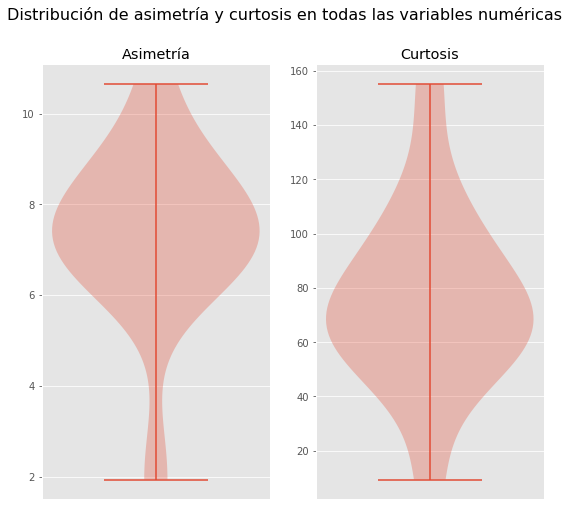

In [91]:
pobData = df[pobTypes]
pobDistStatistics = distributionSkewAndKurtosis(pobData)
print(pobDistStatistics)

fig, axs = plt.subplots(1, 2, figsize=(9, 8))
fig.suptitle("Distribución de asimetría y curtosis en todas las variables numéricas", fontsize=16)
axs[0].violinplot(pobDistStatistics["skew"]);
axs[0].get_xaxis().set_visible(False)
axs[0].set_title("Asimetría");
axs[1].violinplot(pobDistStatistics["kurtosis"]);
axs[1].get_xaxis().set_visible(False)
axs[1].set_title("Curtosis");

Los resultados de la gráfica anterior muestran que la distribución de cada una de las columnas relacionadas con variables poblacionales y económicas para todos los municipios se encuentran alejadas de tener un comportamiento normal. En particular podemos ver que todas ellas tienen tanto la asemitría como la curtosis mayores a cero, lo cual indica que son de cola pesada cargadas hacia la derecha, como la que se muestra debajo.

Total de registros: 2463, municipios con más de 0 ocupados: 928


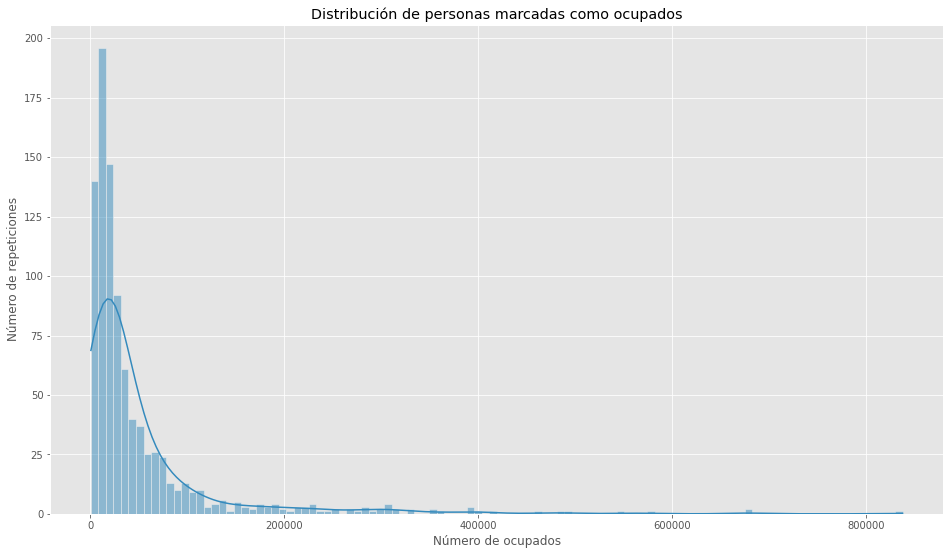

In [92]:
print(f'Total de registros: {pobData.shape[0]}, municipios con más de 0 ocupados: {pobData[pobData["ocupados"] > 0]["ocupados"].count()}')

histpt = sns.histplot(x=pobData[pobData["ocupados"] > 0]["ocupados"], kde=True);
histpt.set_title("Distribución de personas marcadas como ocupados");
histpt.set_xlabel("Número de ocupados");
histpt.set_ylabel("Número de repeticiones");

## **3. Exploración de Variables Categóricas y Análisis Multivariable**

En este Postwork vamos a explorar las distribuciones de las variables categóricas de nuestro dataset. En el postwork pasado exploramos las variables numéricas y ya deberías de tener una idea general bastante buena de cómo están organizadas. Ahora es momento de hacer análisis de variables categóricas y análisis multivariable. 

Realiza los siguientes pasos si tiene sentido aplicarlos a tu conjunto de datos:

1. Si ya tienes gráficas realizadas en Postworks anteriores, agrega títulos, anotaciones y leyendas donde sea necesario. También cambia el tamaño de las gráficas donde tenga sentido hacerlo.
2. Identifica todas las variables categóricas en tu dataset.
3. Utiliza gráficas de barras para explorar la distribución de tus variables categóricas.
4. Planea tu análisis multivariable: ¿qué combinaciones de variables categóricas podrían darme información útil acerca de la distribución de mis datos? ¿qué combinaciones de una variable numérica con una variable categórica podrían ser interesantes?
5. Utiliza tablas de contingencia y múltiples gráficas en la misma figure para explorar combinaciones de variables categóricas.
6. Utiliza boxplots y violinplots para explorar combinaciones de variables numéricas con variables categóricas.
7. De preferencia ve registrando por escrito (ahí mismo en tu Notebook) todos tus hallazgos. Describe qué vas descubriendo y qué podría significar.

Los resultados de arriba muestran la proporción de restaurantes considerados como outliers (mayores a 1.5 veces el tercer curtil) de cada tipo de comida. Esta gráfica refuerza la idea de que la distribución de datos es bastante desigual, observación soportada por los valores de desviación estándar y anteriores estadísticos ya mostrados. Es decir, el 80% de los datos tienen un cierto comportamiento, y el otro 20% uno muy distinto, los cuales modifican ciertos estadísticos como el promedio, pero que resultan de vital importancia y que dejan en claro que existe una dseiguldad en la distribución de los restaurantes en el país.

### Análisis alimentos

In [93]:
fTypes = {'comida_carta_corrida': "Comida corrida", 'pescados_mariscos': "Pescados y mariscos", 'pizzas_hamburguesas_hotdogs_pollos_rostizados': "Comida rápida",
           'tacos_tortas': "Tacos y tortas", 'otro_tipo_alimentos': "Otro"}
foodKeys = fTypes.keys()
foodTypes = ['comida_carta_corrida', 'antojitos', 'pescados_mariscos', 'pizzas_hamburguesas_hotdogs_pollos_rostizados', 'tacos_tortas',
       'autoservicio', 'otro_tipo_alimentos']
food = pd.DataFrame()
for fType in foodTypes:
    tmp = pd.DataFrame(dataframe[fType].values, columns=["Quantity"])
    tmp["Type"] = fType.capitalize() if fType not in foodKeys else fTypes[fType].capitalize()
    food = food.append(tmp)

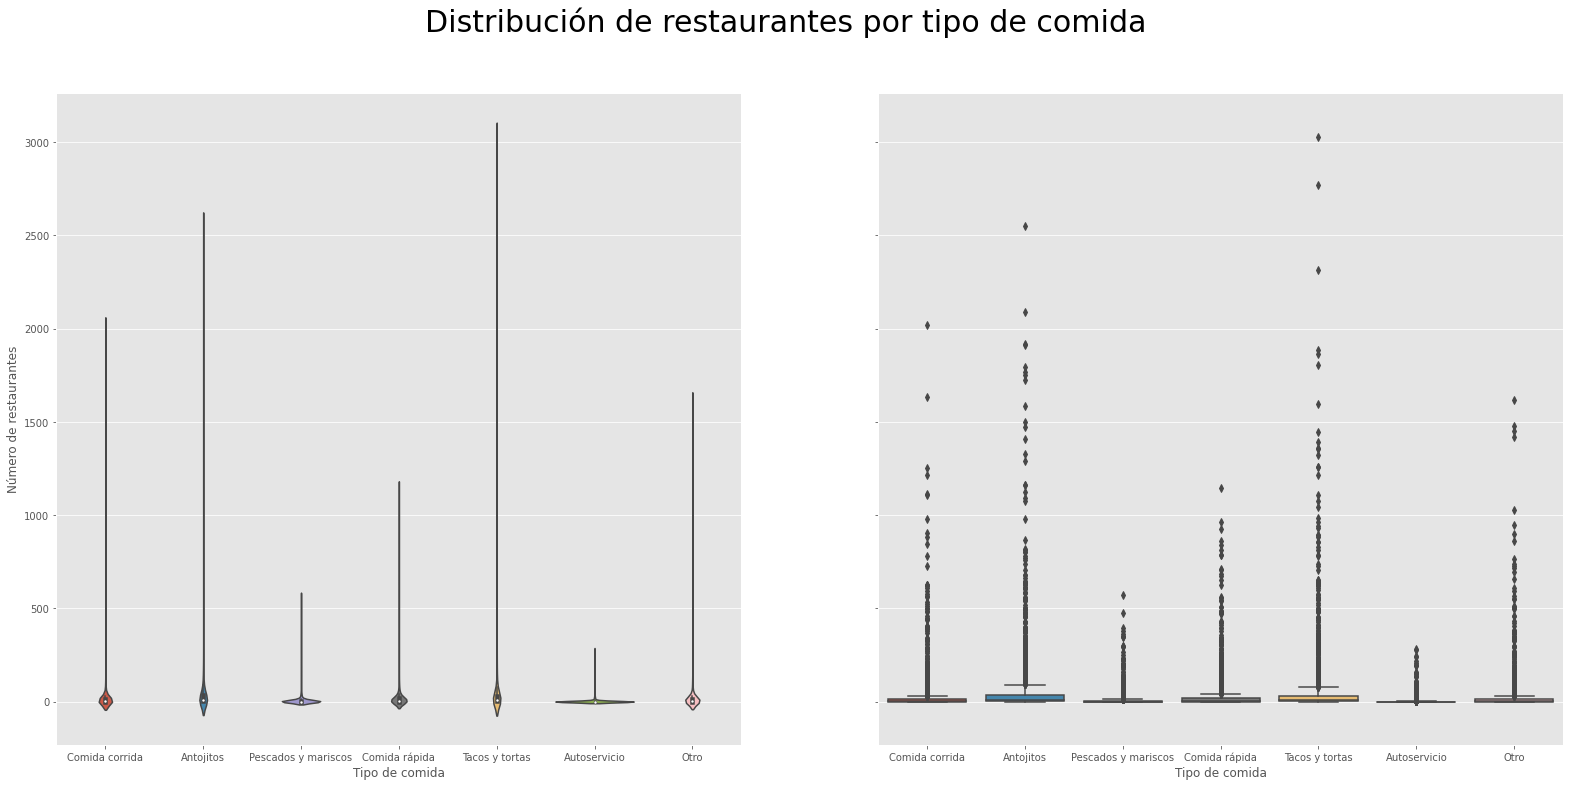

In [94]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9*3, 4*3), sharey=True)

fig.suptitle("Distribución de restaurantes por tipo de comida", fontsize=30)
violin = sns.violinplot(ax=axs[0], x="Type", y="Quantity", data=food);
violin.set(xlabel='Tipo de comida', ylabel='Número de restaurantes');
boxpt = sns.boxplot(ax=axs[1], x="Type", y="Quantity", data=food);
boxpt.set(xlabel='Tipo de comida', ylabel=None);

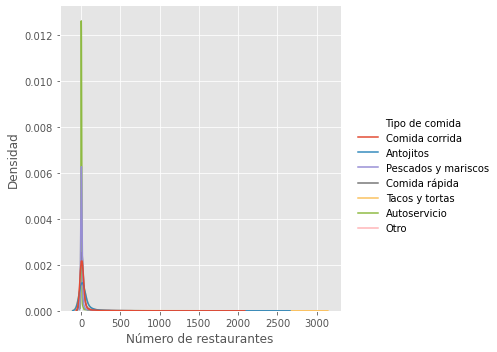

In [95]:
"""sns.kdeplot(
   data=food, x="Quantity", hue="Type",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0
);"""

kdept = sns.displot(data=food, x="Quantity", kind="kde", hue="Type");
kdept.set(xlabel='Número de restaurantes', ylabel="Densidad");
kdept._legend.set_title("Tipo de comida");

In [96]:
generarEstadisticos(df[foodTypes])

promedio  ...  rango intercuartílico
comida_carta_corrida                           26.553390  ...                   12.0
antojitos                                      56.247665  ...                   36.0
pescados_mariscos                               9.911084  ...                    5.0
pizzas_hamburguesas_hotdogs_pollos_rostizados  27.670321  ...                   17.0
tacos_tortas                                   54.974421  ...                   31.0
autoservicio                                    4.040195  ...                    1.0
otro_tipo_alimentos                            25.425903  ...                   12.0

[7 rows x 10 columns]

En este caso, a pesar de que existen bastantes valores atípicos, y que las distribuciones de los valores están centradas en valores chicos, aquellos con valores grandes no son precisamente datos fuera de lugar, sino de municipios con grandes urbes como las alcaldías de la CDMX. Por tanto no se requiere elmininarlas, puesto que son importantes aunque muestran la realidad de nuestro país, donde la mayoría de los municipios cuentan con pocos restaurantes, sin importar el tipo de comida. Aunado a ello, en el boxplot (así como en los estadísticos), no hay valores negativos, es decir, todos son válidos. Más adelante se tratará de identificar si realmente son los munipios con mayor número de pobladores aquellos que tiene mayor número de restaurantes, y si lo tienen en todos los tipos de restaurantes.

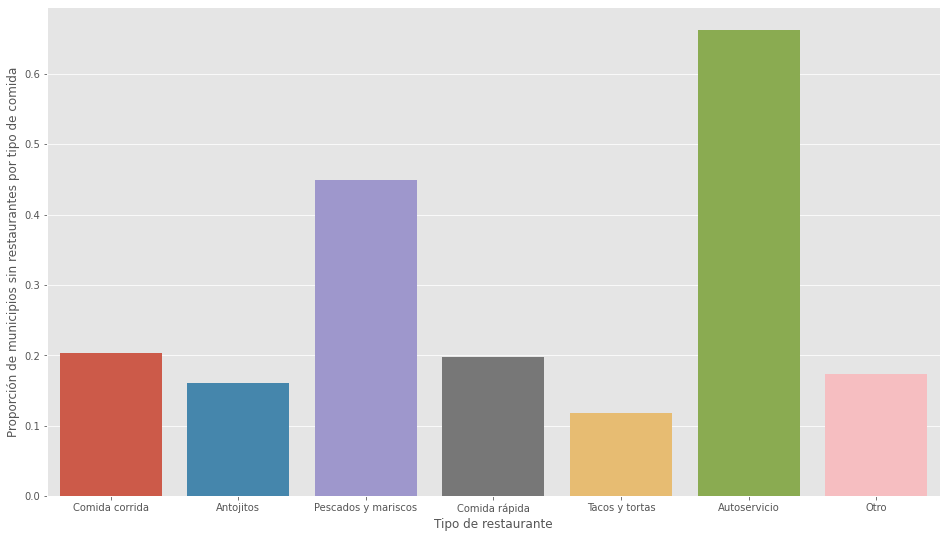

In [97]:
onlyFood = dataframe[foodTypes]
zeroRestaurants = (onlyFood == 0).sum() / onlyFood.count()
bpt = sns.barplot(x=[ind.capitalize() if ind not in fTypes.keys() else fTypes[ind].capitalize() for ind in zeroRestaurants.index], y=zeroRestaurants);
bpt.set_xlabel("Tipo de restaurante");
bpt.set_ylabel("Proporción de municipios sin restaurantes por tipo de comida");

Habría que analizar si todos estos valores en cero son realmente por la ausencia de restaurantes de ese tipo, o no fueron contados de manera correcta. Este análisis se tendría que realizar a fondo con los creadores de la base de datos de donde se tomaron estos valores.

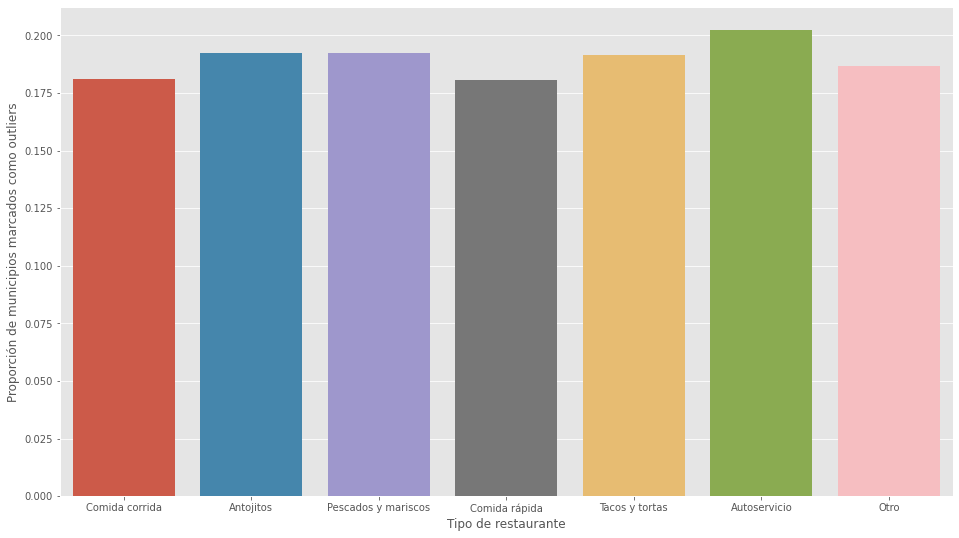

In [98]:
outlier = onlyFood.quantile(0.75)*1.5
foodOutliers = (onlyFood > outlier).sum() / onlyFood.count()
bpt = sns.barplot(x=[ind.capitalize() if ind not in fTypes.keys() else fTypes[ind].capitalize() for ind in foodOutliers.index], y=foodOutliers);
bpt.set_xlabel("Tipo de restaurante");
bpt.set_ylabel("Proporción de municipios marcados como outliers");

In [99]:
import numpy as np
food = pd.DataFrame()
for fType in foodTypes:
    tmp = pd.DataFrame(dataframe[fType].values, columns=["Quantity"])
    tmp["Pob"] = dataframe["pob"].values
    tmp["Type"] = fType.capitalize() if fType not in foodKeys else fTypes[fType].capitalize()
    food = food.append(tmp)
food = food[food["Pob"] > 0] # remove all zero pob
food["Pob per restaurant"] =  food["Pob"] / food["Quantity"]
food = food.replace([np.inf, -np.inf], 0) # repalce inf from non restaurant values with zeros
food.describe()

Quantity           Pob  Pob per restaurant
count  17199.000000  1.719900e+04        17199.000000
mean      29.307343  5.249184e+04         3690.819354
std      114.641943  1.487503e+05         8230.513670
min        0.000000  9.700000e+01            0.000000
25%        0.000000  4.495000e+03            0.000000
50%        3.000000  1.421400e+04         1381.000000
75%       15.000000  3.755300e+04         3574.810000
max     3030.000000  1.815100e+06       202476.000000

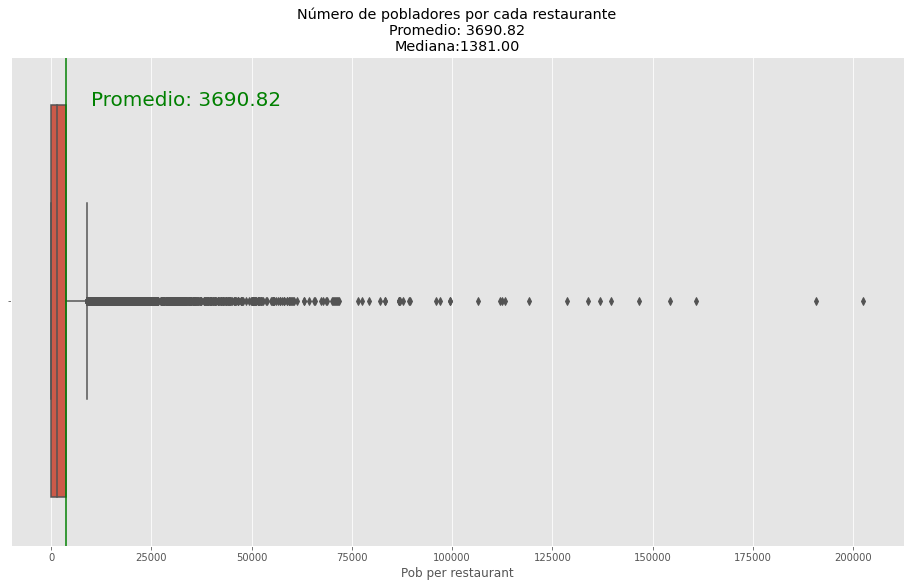

In [100]:
sns.boxplot(x="Pob per restaurant", data=food, width=0.8);
mn = food["Pob per restaurant"].mean()
md = food["Pob per restaurant"].median()
plt.axvline(mn, 0, 1, color="g");
plt.title(f"Número de pobladores por cada restaurante\nPromedio: {mn:.2f}\nMediana:{md:.2f}");
plt.annotate(f"Promedio: {mn:.2f}", (10000, -0.4), fontsize=20, color="g");

Dividir en tres categorías los datos de personas por restaurante: valores debajo de la mediana, valores mayores de la mediana y hasta el bigote del boxplot (1.5 veces el rango intercuartílico) y los outliers.

In [101]:
md = food["Pob per restaurant"].median()
interQ = food["Pob per restaurant"].quantile(0.75) - food["Pob per restaurant"].quantile(0.25)
food["Grupo pobladores por negocio"] = food["Pob per restaurant"].apply(lambda x: "Menor a mediana" if x < md else "Mayor a mediana" if x < interQ * 1.5 else "Outlier")
gb = food.groupby(["Type", "Grupo pobladores por negocio"])["Quantity"].count()
gb = gb.reset_index()
gb

Type Grupo pobladores por negocio  Quantity
0             Antojitos              Mayor a mediana       768
1             Antojitos              Menor a mediana      1554
2             Antojitos                      Outlier       135
3          Autoservicio              Mayor a mediana        56
4          Autoservicio              Menor a mediana      1631
5          Autoservicio                      Outlier       770
6        Comida corrida              Mayor a mediana      1132
7        Comida corrida              Menor a mediana       863
8        Comida corrida                      Outlier       462
9         Comida rápida              Mayor a mediana      1343
10        Comida rápida              Menor a mediana       921
11        Comida rápida                      Outlier       193
12                 Otro              Mayor a mediana      1051
13                 Otro              Menor a mediana       924
14                 Otro                      Outlier       482
15  Pescados y mariscos              Mayor a mediana       482
16  Pescados y mariscos              Menor a mediana      1154
17  Pescados y mariscos                      Outlier       821
18       Tacos y tortas              Mayor a mediana       791
19       Tacos y tortas              Menor a mediana      1552
20       Tacos y tortas                      Outlier       114

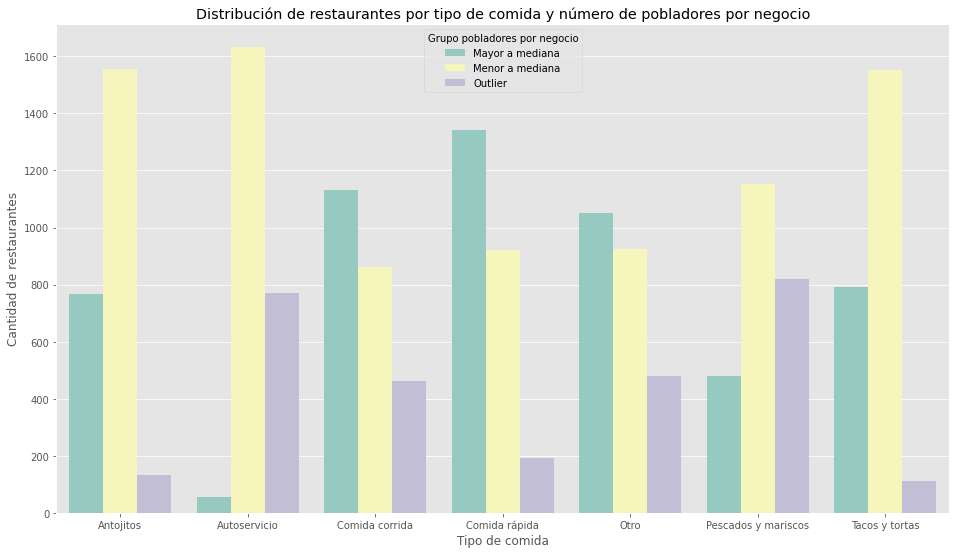

In [102]:
ax = sns.barplot(x="Type", y="Quantity", hue="Grupo pobladores por negocio", data=gb, palette="Set3")
ax.set(xlabel='Tipo de comida', ylabel='Cantidad de restaurantes', title="Distribución de restaurantes por tipo de comida y número de pobladores por negocio");

La gráfica anterior lo que muestra es la cantidad de negocios que se encuentran por debajo de la mediana del número de pobladores por establecimiento, por encima y hasta el valor de 1.5 veces el IQR (rango inter cuartílico) o si son outliers. De aquí podemos observar varios factores, por ejemplo que en el caso de la comida corrida y la comida rápida, así como en la categoría de otros, hay más establecimientos que atienden a un grupo mayor de personas que la mediana, es decir, tienen un mayor número de clientes potenciales. A su vez esto podría ser un indicador de que hay mayor oportunidad para poner un negocio de este estilo, puesto que cuenta con un gran número de pobladores para un solo negocio, y por tanto hay menor competencia.

Por otro lado, los casos de las tiendas de autoservicio y de pescados y mariscos tienen la particularidad de que hay lugares donde, o cuentan con pocos (menos de la mediana) número de clientes potenciales (pobladores por negocio), o el segundo grupo más numeroso es aquel con outliers, es decir, con un gran número de pobladores para cada negocio. Esto nuevamente es un área de oportunidad para abrir negocios de este estilo, tomando en cuenta que las tiendas de autoservicio en su mayoría están diseñadas para atender a grandes cantidades de personas, idea reforzada por los resultados, donde los valores por encima de la mediana y sin ser outliers son muy bajos comparados con los otros dos grupos. Pero, el caso de los restaurantes de mariscos es interesante, ya que generalmente son lugares sin tanta capacidad de clientes, pero que dadas las gráficas, tienden a tener una alta cantidad de pobladores potenciales.

## **4. Correlaciones y Regresión Linear Simple**

En este Postwork vamos a hacer análisis bivariado de nuestras variables numéricas. Si tu dataset sólo tiene variables categóricas o datos no estructurados (texto libre), entonces puedes pedirle a tu experta que te comparta algún dataset con el que puedas realizar estos ejercicios.

Utilizando tu dataset, realiza las siguientes actividades:

1. Identifica cuáles son las variables numéricas en tu dataset.
2. Asegúrate de que tengan el tipo de dato correcto y que no haya NaNs por ahí escondidos.
3. Genera una matriz de correlaciones y un pairplot para visualizar de manera general las relaciones entre tus variables numéricas.
4. Utilizando gráficas de dispersión y tus medidas de locación y dispersión, identifica dónde hay valores atípicos y decide qué hacer con ellos.
5. Revisa si tu revisión de valores atípicos cambió de alguna manera las relaciones existentes.
6. Donde consideres necesario, entrena modelos de Regresión Lineal con un o más pares de variables. Incluso si no te parece que realizar predicciones entre pares de variables tiene sentido para tu proyecto, prueba realizar un par de regresiones para que practiques el procedimiento.

In [103]:
# Creamos una copia de nuestro dataframe
df_pw4 = dataframe
df_pw4.head()

imun  ent         nom_ent  ...  autoservicio otro_tipo_alimentos  CVEGEO
2  1001    1  Aguascalientes  ...          96.0               338.0   01001
3  1002    1  Aguascalientes  ...           0.0                 5.0   01002
4  1003    1  Aguascalientes  ...           2.0                 4.0   01003
5  1004    1  Aguascalientes  ...           0.0                 2.0   01004
6  1005    1  Aguascalientes  ...           3.0                28.0   01005

[5 rows x 27 columns]

Se identifican diversas variables numéricas dentro del dataset. Procedemos a seleccionar ciertas columnas y observar si existe una correlación entre las mismas.

### Población y tipo de restaurantes por entidad

Tomamos como punto de partida, la variable de población junto con las variables que representan a cada tipo de restaurante. Para un mejor análisis, realizamos la matriz de correlación dependiendo la entidad que seleccionemos. En este caso tomamos 3: Ciudad de México, Veracruz y Oaxaca

#### **Ciudad de México**

In [104]:
# Tomamos la entidad de interés
ent = 9

filtro = df_pw4['ent'] == ent

d1 = df_pw4[filtro]

#Enlistamos las columnas de interés para obtener la matriz de correlación
lista = ['pob','comida_carta_corrida','antojitos','pescados_mariscos','pizzas_hamburguesas_hotdogs_pollos_rostizados','tacos_tortas','autoservicio','otro_tipo_alimentos']

d1 = d1[lista]

diccionario = ['Población','A','B','C','D','E','F','G']

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

d1.columns = diccionario

# Verificamos si existen NaN's en las columnas
na = d1.isna().sum().sum()

print(f'Número de NaN en el dataframe: {na}')

d1.head()

Número de NaN en el dataframe: 0


Población      A       B      C      D       E     F       G
280   407280.0  388.0   503.0   74.0  153.0   544.0  68.0   457.0
281   620486.0  569.0   491.0   99.0  249.0   633.0  99.0   433.0
282   199926.0  202.0   182.0   29.0   80.0   201.0  49.0   127.0
283  1173555.0  627.0  1328.0  185.0  510.0  1322.0  96.0  1029.0
284   393275.0  262.0   459.0   81.0  153.0   426.0  20.0   371.0

In [105]:
d1_corr = d1.corr()
d1_corr

Población         A         B  ...         E         F         G
Población   1.000000  0.213604  0.922596  ...  0.840863  0.500581  0.893759
A           0.213604  1.000000  0.277152  ...  0.643397  0.919361  0.478027
B           0.922596  0.277152  1.000000  ...  0.903801  0.493033  0.967817
C           0.886071  0.528883  0.925712  ...  0.971285  0.705142  0.968114
D           0.971898  0.380917  0.926501  ...  0.916101  0.619837  0.942501
E           0.840863  0.643397  0.903801  ...  1.000000  0.794503  0.969787
F           0.500581  0.919361  0.493033  ...  0.794503  1.000000  0.665651
G           0.893759  0.478027  0.967817  ...  0.969787  0.665651  1.000000

[8 rows x 8 columns]

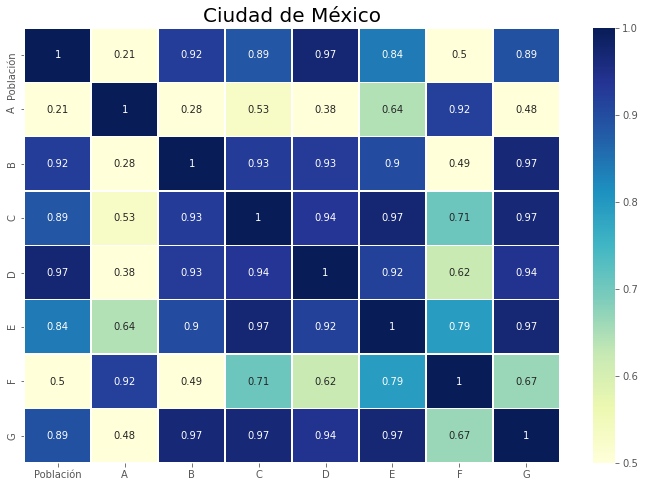

In [106]:
plt.figure(figsize=(12, 8))
ax = sns.heatmap(d1_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);
ax.set_title('Ciudad de México',fontsize = 20);

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

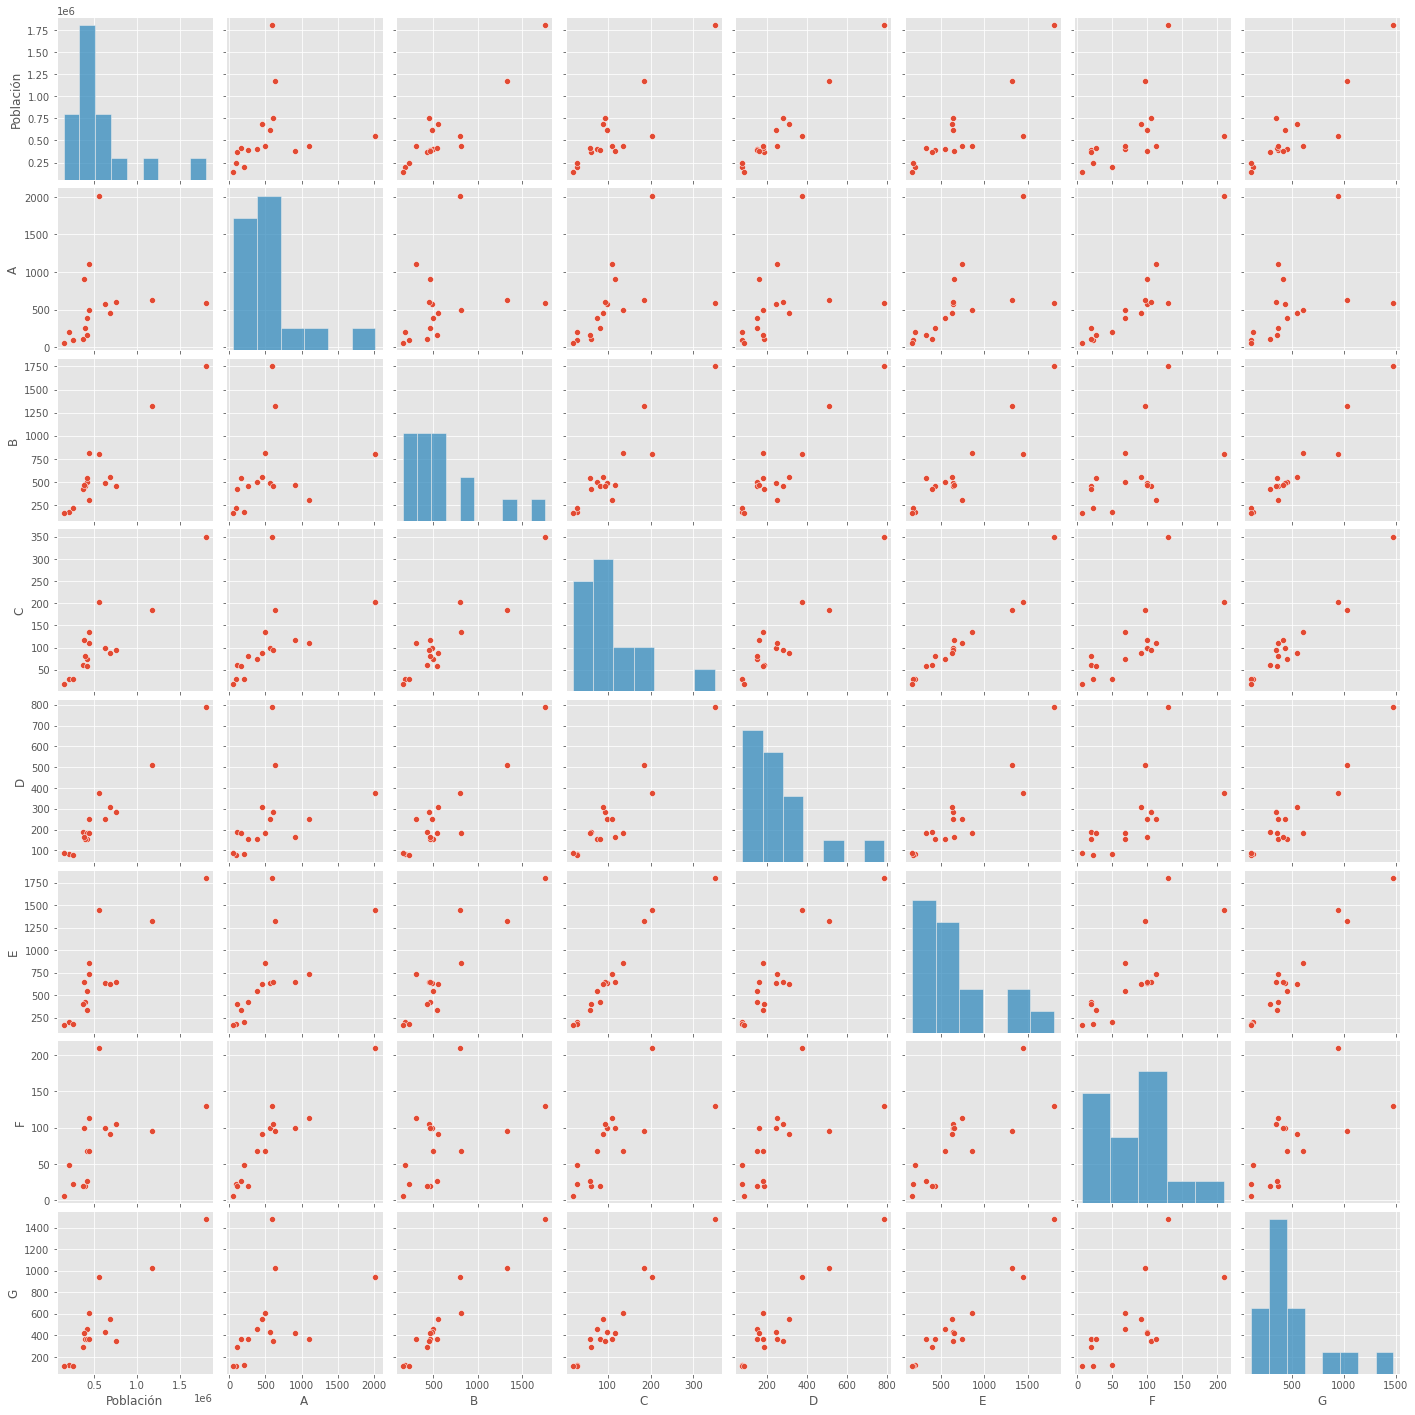

In [107]:
sns.pairplot(d1);

#### **Veracruz**

In [108]:
# Tomamos la entidad de interés
ent = 30

filtro = df_pw4['ent'] == ent

d2 = df_pw4[filtro]

#Enlistamos las columnas de interés para obtener la matriz de correlación
lista = ['pob','comida_carta_corrida','antojitos','pescados_mariscos','pizzas_hamburguesas_hotdogs_pollos_rostizados','tacos_tortas','autoservicio','otro_tipo_alimentos']

d2 = d2[lista]

diccionario = ['Población','A','B','C','D','E','F','G']

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

d2.columns = diccionario

# Verificamos si existen NaN's en las columnas
na = d2.isna().sum().sum()

print(f'Número de NaN en el dataframe: {na}')

d2.head()

Número de NaN en el dataframe: 0


Población     A      B     C     D     E    F     G
2118     9168.0   4.0   10.0   0.0   2.0   2.0  1.0   8.0
2119     3360.0   1.0    2.0   0.0   2.0   7.0  0.0   4.0
2120    91514.0  58.0  180.0  39.0  60.0  73.0  6.0  22.0
2121    46155.0   4.0   41.0   4.0  11.0  13.0  0.0   5.0
2122     5728.0   1.0    4.0   2.0   0.0   5.0  0.0   1.0

In [109]:
d2_corr = d2.corr()
d2_corr

Población         A         B  ...         E         F         G
Población   1.000000  0.920286  0.910292  ...  0.957508  0.877435  0.834230
A           0.920286  1.000000  0.843721  ...  0.933872  0.899695  0.926310
B           0.910292  0.843721  1.000000  ...  0.923591  0.883229  0.726379
C           0.885313  0.835000  0.929870  ...  0.885166  0.886763  0.683176
D           0.946405  0.946307  0.868617  ...  0.939524  0.897752  0.920644
E           0.957508  0.933872  0.923591  ...  1.000000  0.872901  0.836520
F           0.877435  0.899695  0.883229  ...  0.872901  1.000000  0.818162
G           0.834230  0.926310  0.726379  ...  0.836520  0.818162  1.000000

[8 rows x 8 columns]

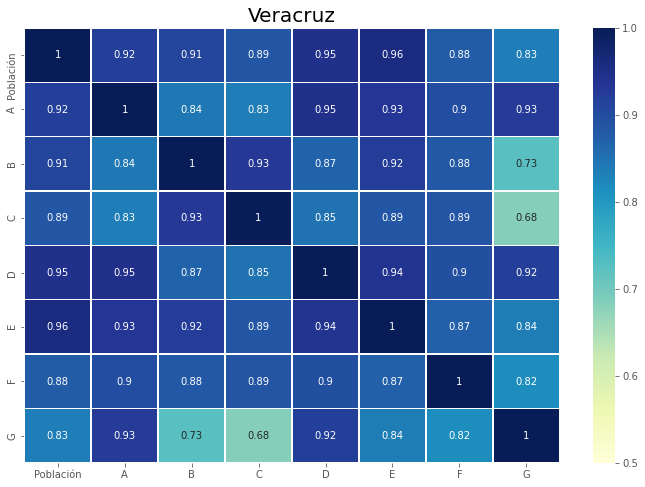

In [110]:
plt.figure(figsize=(12, 8))
ax = sns.heatmap(d2_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);
ax.set_title('Veracruz',fontsize = 20);

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

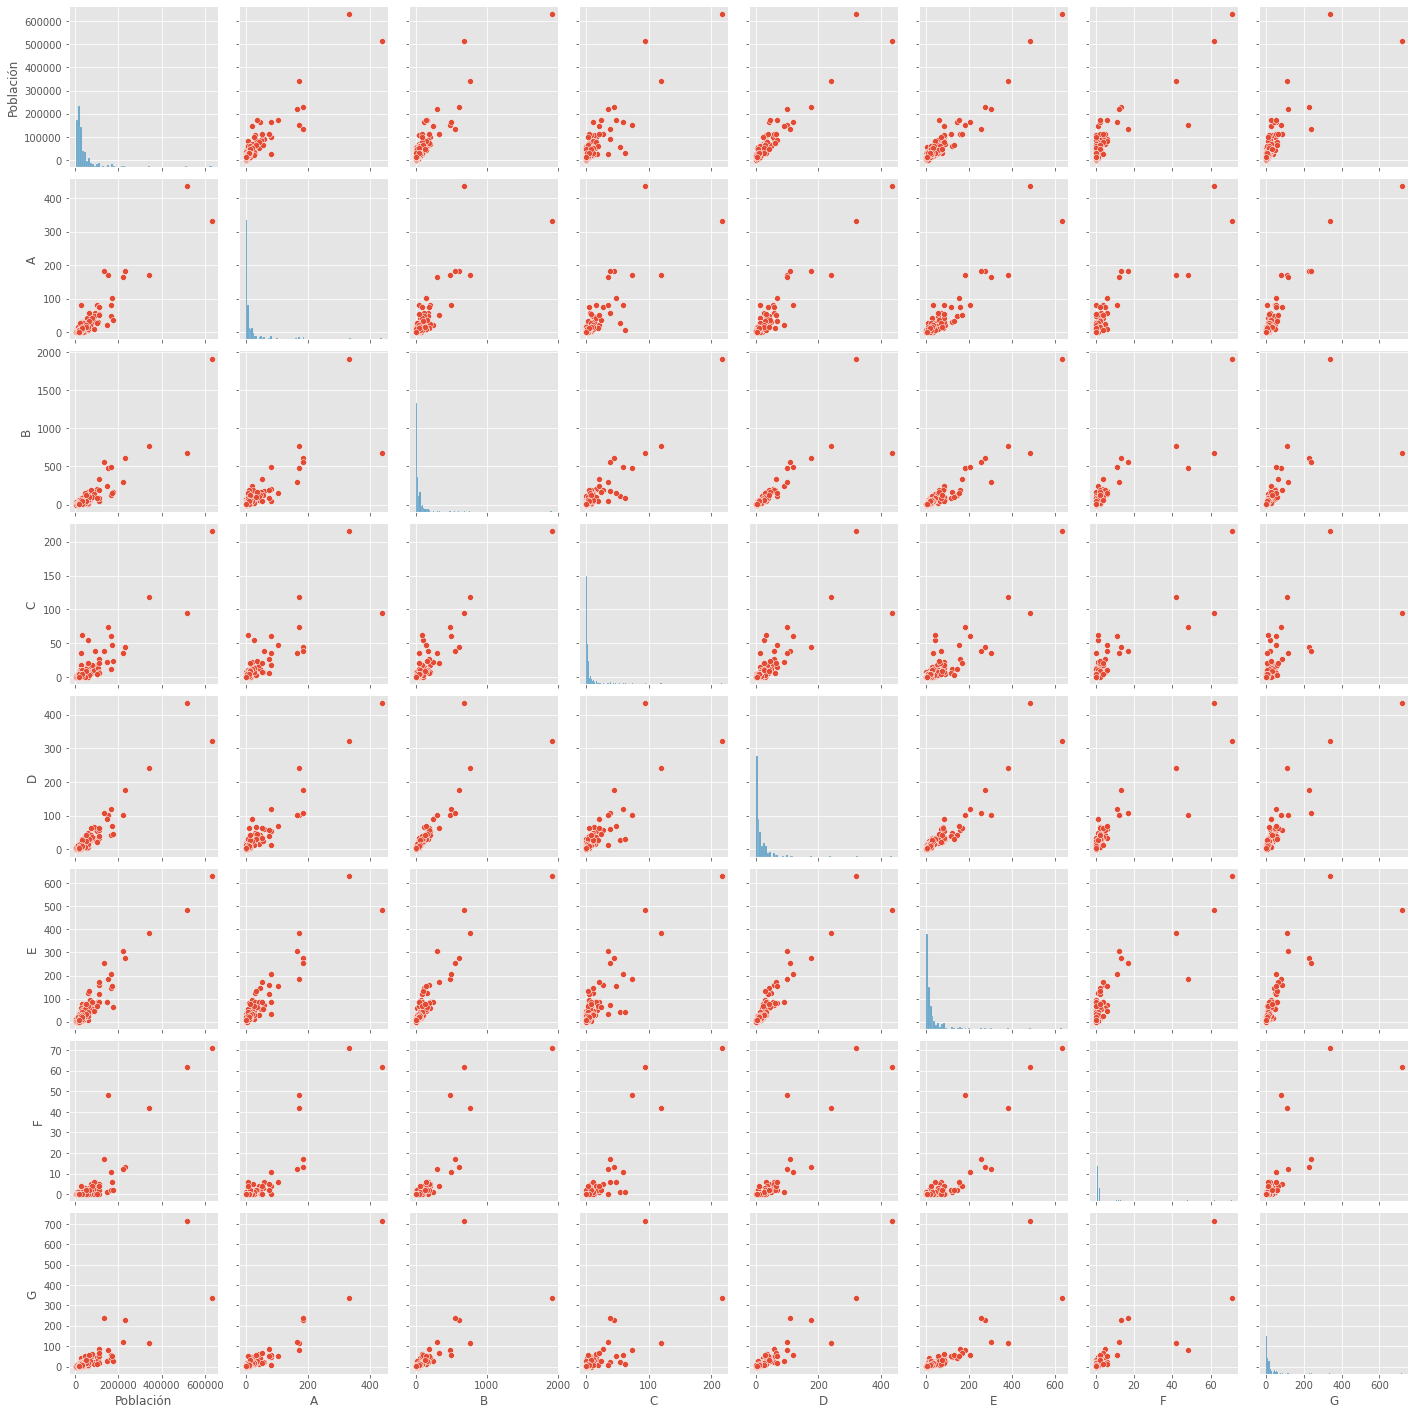

In [111]:
sns.pairplot(d2);

#### **Oaxaca**

In [112]:
# Tomamos la entidad de interés
ent = 20

filtro = df_pw4['ent'] == ent

d3 = df_pw4[filtro]

#Enlistamos las columnas de interés para obtener la matriz de correlación
lista = ['pob','comida_carta_corrida','antojitos','pescados_mariscos','pizzas_hamburguesas_hotdogs_pollos_rostizados','tacos_tortas','autoservicio','otro_tipo_alimentos']

d3 = d3[lista]

diccionario = ['Población','A','B','C','D','E','F','G']

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

d3.columns = diccionario

# Verificamos si existen NaN's en las columnas
na = d3.isna().sum().sum()

print(f'Número de NaN en el dataframe: {na}')

d3.head()

Número de NaN en el dataframe: 0


Población     A     B    C     D     E    F     G
1024     1019.0   0.0   0.0  0.0   0.0   1.0  0.0   1.0
1025    47807.0  10.0  68.0  3.0  37.0  73.0  0.0  26.0
1026     2172.0   0.0   0.0  0.0   0.0   0.0  0.0   4.0
1027     1035.0   2.0   1.0  0.0   0.0   1.0  1.0   1.0
1028    15904.0  11.0  26.0  1.0   4.0   7.0  0.0  18.0

In [113]:
d3_corr = d3.corr()
d3_corr

Población         A         B  ...         E         F         G
Población   1.000000  0.812165  0.905482  ...  0.939217  0.811226  0.900453
A           0.812165  1.000000  0.719760  ...  0.931666  0.950039  0.868240
B           0.905482  0.719760  1.000000  ...  0.859588  0.746470  0.917148
C           0.737236  0.740830  0.811332  ...  0.765319  0.699083  0.823135
D           0.957470  0.883499  0.881987  ...  0.975218  0.889949  0.936693
E           0.939217  0.931666  0.859588  ...  1.000000  0.922274  0.929312
F           0.811226  0.950039  0.746470  ...  0.922274  1.000000  0.894544
G           0.900453  0.868240  0.917148  ...  0.929312  0.894544  1.000000

[8 rows x 8 columns]

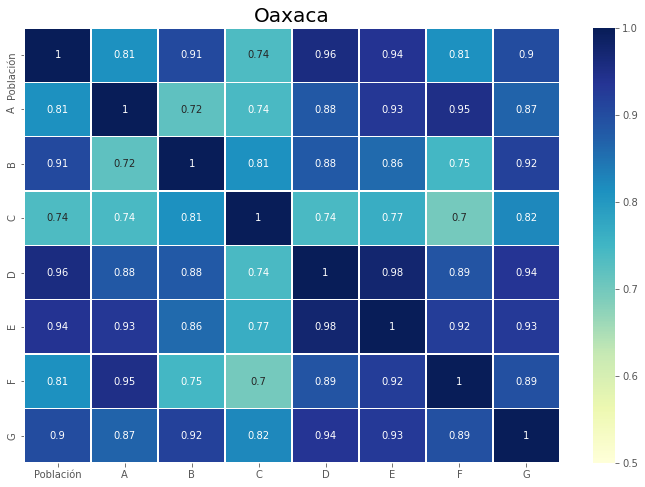

In [114]:
plt.figure(figsize=(12, 8))
ax = sns.heatmap(d3_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);
ax.set_title('Oaxaca',fontsize = 20);

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

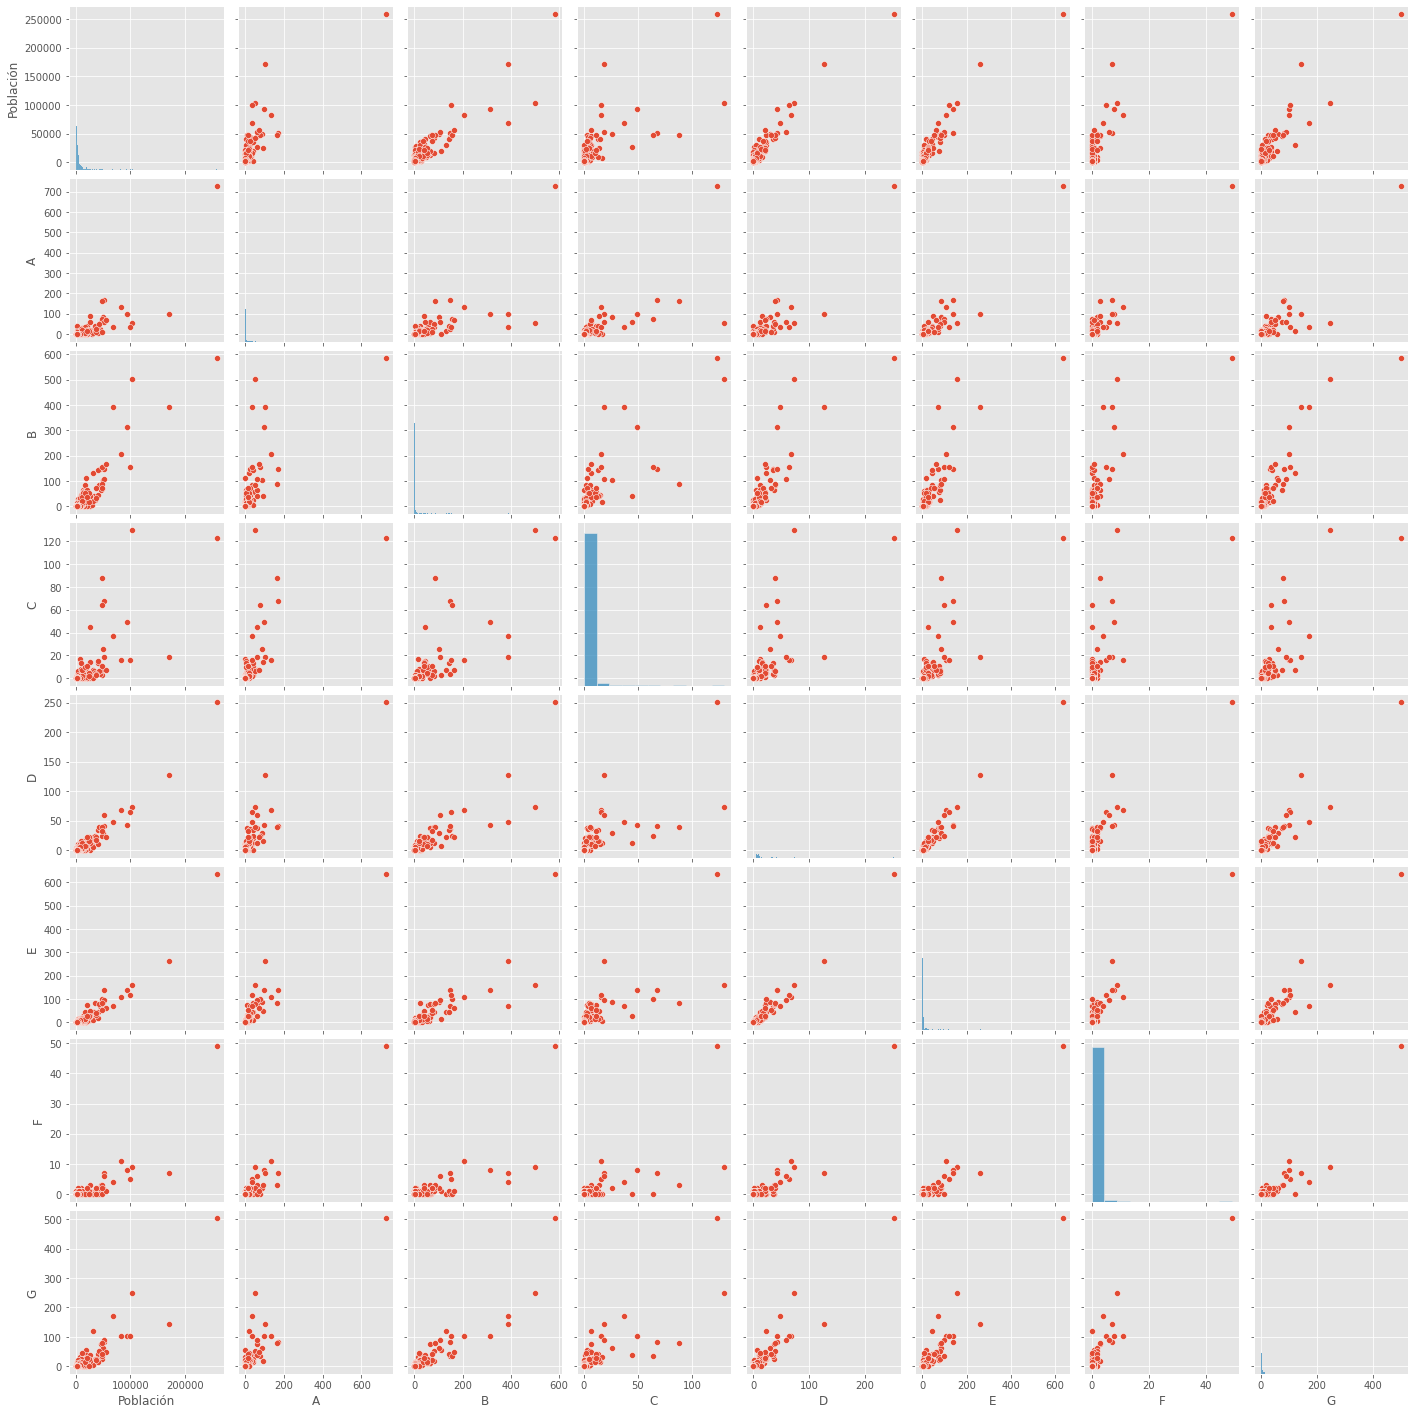

In [115]:
sns.pairplot(d3);

#### **Comparativa**

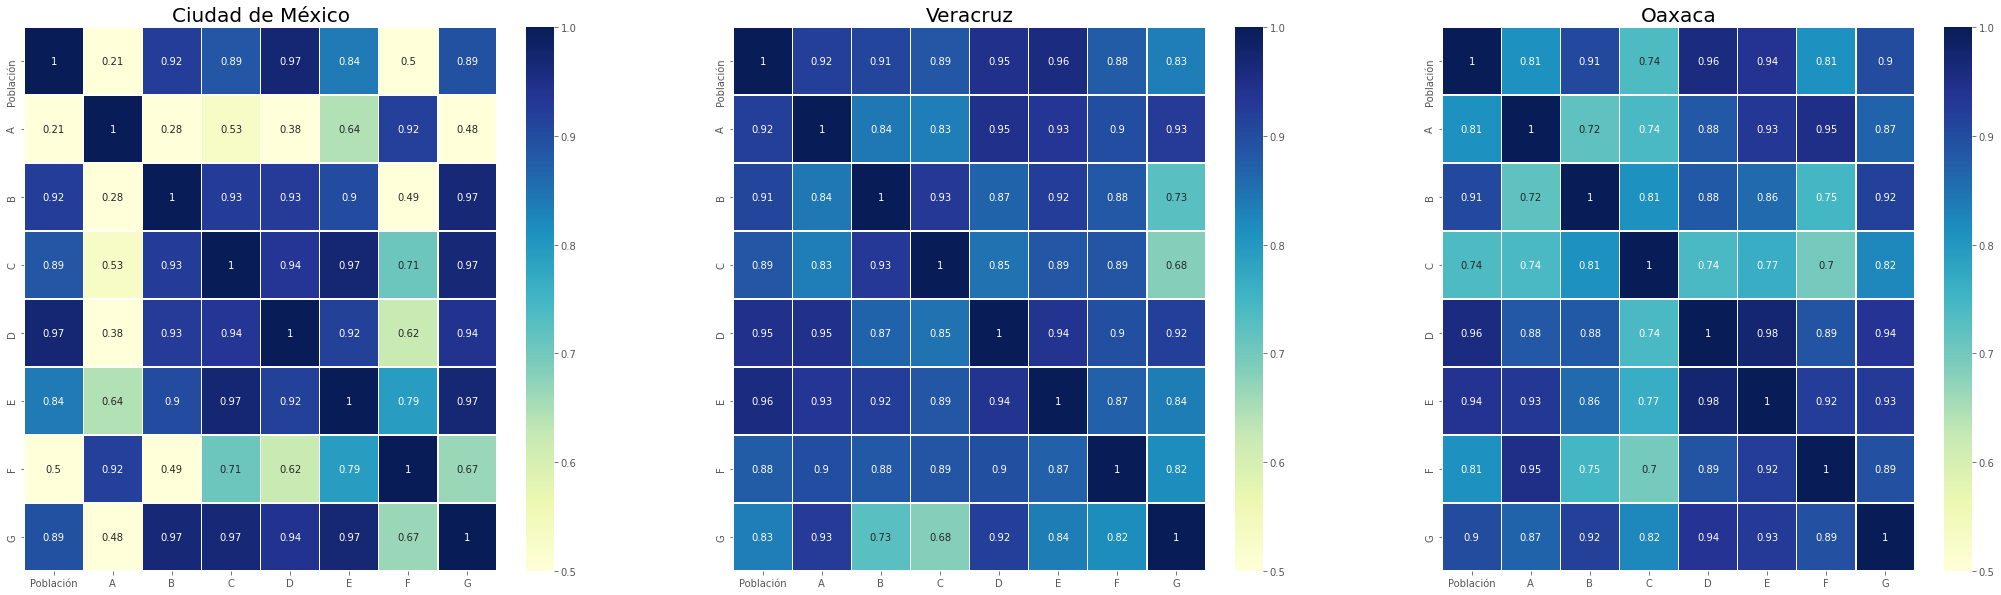

In [116]:
fig,ax =plt.subplots(1,3, figsize=(36, 10))

sns.heatmap(d1_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5,ax=ax[0]);
sns.heatmap(d2_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5,ax=ax[1]);
sns.heatmap(d3_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5,ax=ax[2]);

ax[0].set_title('Ciudad de México',fontsize = 20);
ax[1].set_title('Veracruz',fontsize = 20);
ax[2].set_title('Oaxaca',fontsize = 20);

# Población -> pob
# A         -> comida_carta_corrida
# B         -> antojitos
# C         -> pescados_mariscos
# D         -> pizzas_hamburguesas_hotdogs_pollos_rostizados
# E         -> tacos_tortas
# F         -> autoservicio
# G         -> otro_tipo_alimentos

Nuestra comparativa nos muestra resultados interesantes. Para los establecimientos con comida corrida, nos indica una alta correlación con los de autoservicio. Se puede observar también que las correlaciones entre población y los distintos tipos de restaurante cambian entre entidades, no obstante, es importante considerar que existe una posibilidad que esto se deba a la diferencia de municipios en otras entidades comparado con los de la Ciudad de México.

### Población, ingreso laboral, ocupados y desocupados

In [117]:
lista = ['pobtot','ing_lab','ocupados','desocupados']

d4 = df_pw4[lista]

filtro = d4['ing_lab'] != 0
d4 = d4[filtro]

# Verificamos si existen NaN's en las columnas
na = d4.isna().sum().sum()

print(f'Número de NaN en el dataframe: {na}')

d4.head()

Número de NaN en el dataframe: 0


pobtot  ing_lab  ocupados  desocupados
2  877190.0  7676.46  300564.0      24836.0
3   46464.0  5863.52    8138.0        693.0
4   56048.0  5784.97   14757.0        199.0
5   15577.0  6096.05    3801.0         87.0
6  120405.0  6262.18   37341.0       3187.0

In [118]:
d4_corr = d4.corr()
d4_corr

pobtot   ing_lab  ocupados  desocupados
pobtot       1.000000  0.287626  0.915010     0.812092
ing_lab      0.287626  1.000000  0.278456     0.224929
ocupados     0.915010  0.278456  1.000000     0.764730
desocupados  0.812092  0.224929  0.764730     1.000000

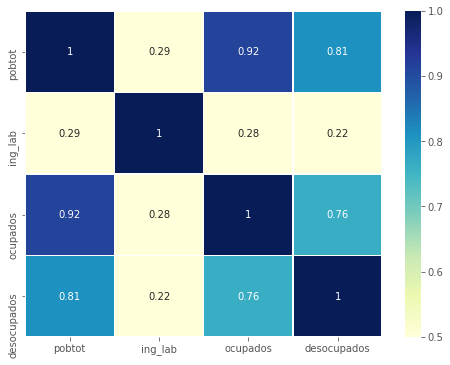

In [119]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(d4_corr, vmin=0.5, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);

La matriz de correlación únicamente nos muestra que existe una fuerte correlación entre la población y el númerom de ocupados, no nos proporciona mucha información.

### Regresión lineal

Se toma como final la de población y tipos de restaurantes para la regresión lineal. En nuestro caso, no existen como tal valores atípicos para el análisis realizado en las matrices de correlación, ya que los valores que toman las variables contienen datos que son de interés.

In [120]:
d5 = df_pw4

#Enlistamos las columnas de interés para obtener la matriz de correlación
lista = ['pobtot','ing_lab','comida_carta_corrida','antojitos','pescados_mariscos','pizzas_hamburguesas_hotdogs_pollos_rostizados','tacos_tortas','autoservicio','otro_tipo_alimentos']

d5 = d5[lista]

filtro = d5['ing_lab'] != 0

d5 = d5[filtro]

d5['total_restaurantes'] = d5[lista[2:]].sum(axis = 1)

d5 = d5.melt(id_vars=['pobtot','ing_lab','total_restaurantes'])

d5.head()

pobtot  ing_lab  total_restaurantes              variable  value
0  877190.0  7676.46              4672.0  comida_carta_corrida  402.0
1   46464.0  5863.52               106.0  comida_carta_corrida    6.0
2   56048.0  5784.97               230.0  comida_carta_corrida   14.0
3   15577.0  6096.05                44.0  comida_carta_corrida    0.0
4  120405.0  6262.18               501.0  comida_carta_corrida   28.0

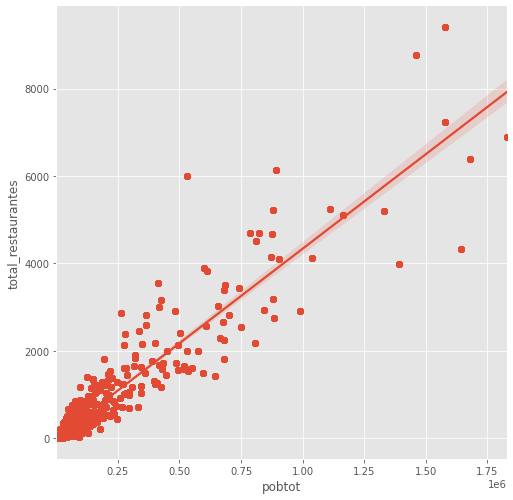

In [121]:
sns.lmplot(x='pobtot',y='total_restaurantes',data = d5,height = 7);

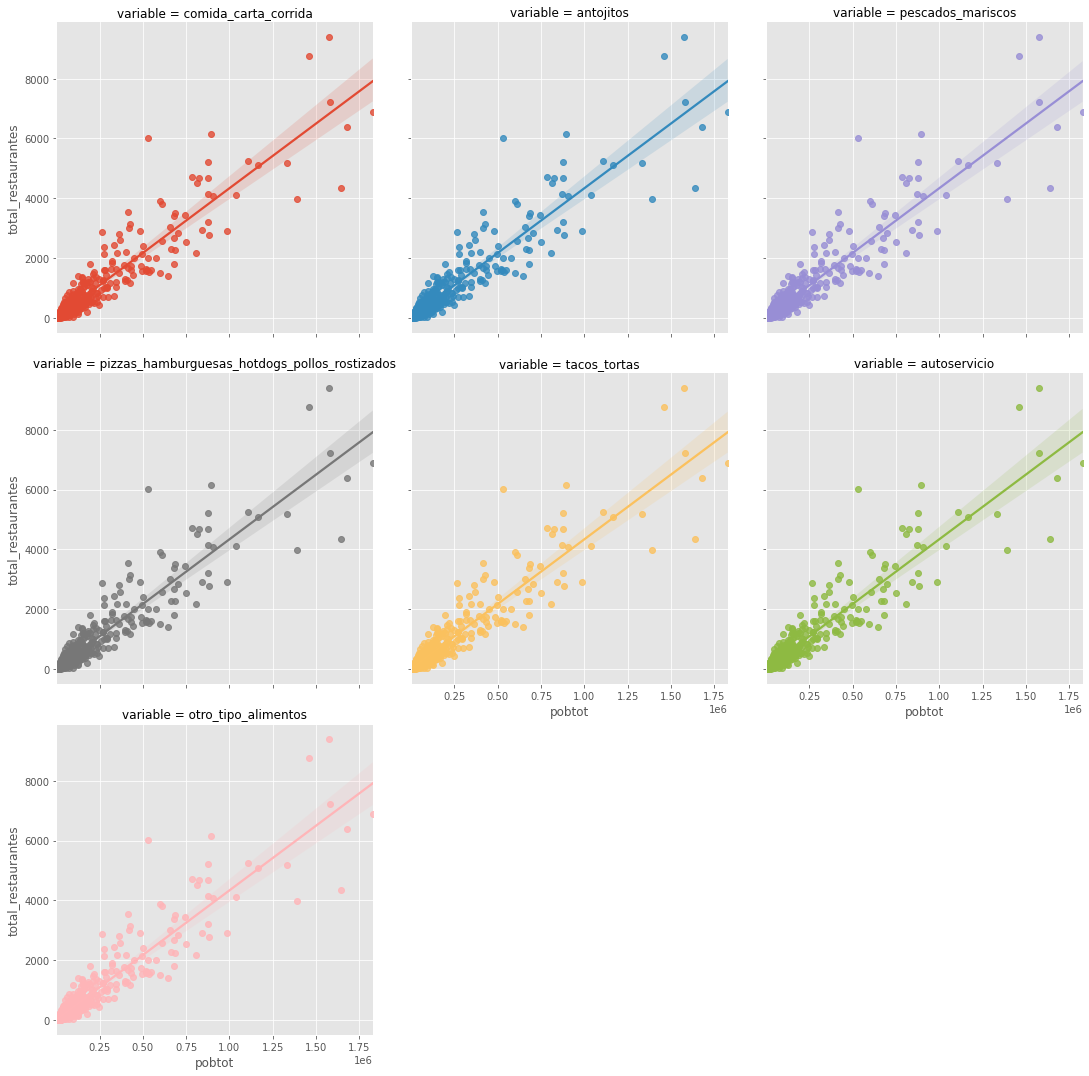

In [122]:
sns.lmplot(x='pobtot',y='total_restaurantes',data = d5,hue = 'variable',col='variable',col_wrap=3);

El resultado mostrado, corresponde a la regresión lineal comparando la población total y el total de restaurantes. Se observa que la regresión lineal muestra resultados correctos, esto se verifica más adelante en el PostWork 5, donde se muestra más detalladamente esta regresión linear.

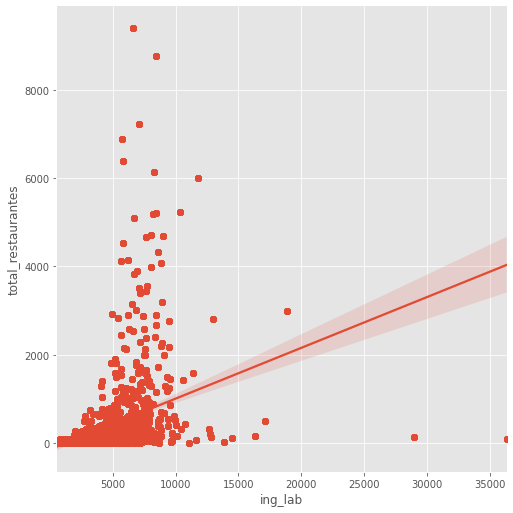

In [123]:
sns.lmplot(x='ing_lab',y='total_restaurantes',data = d5,height = 7);

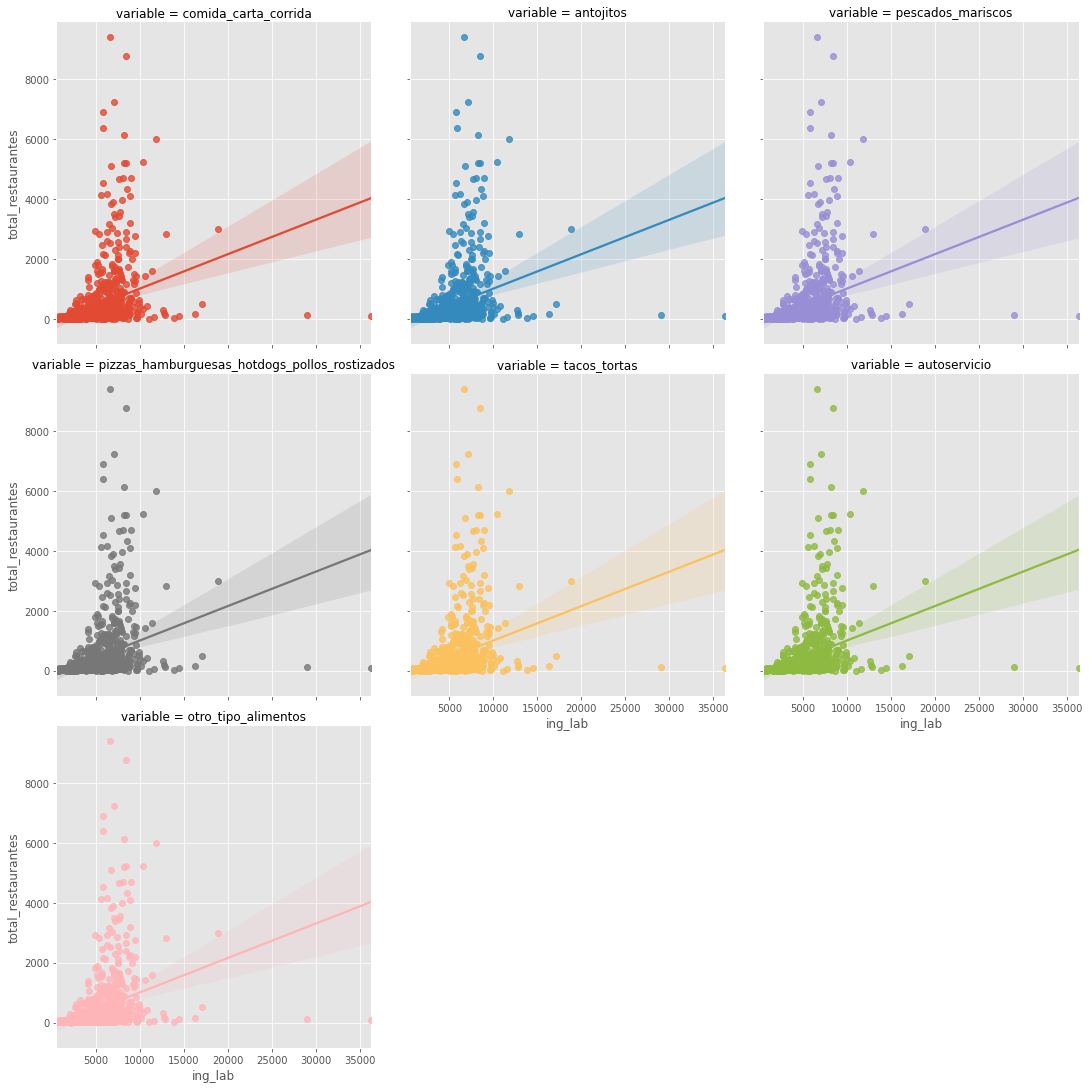

In [124]:
sns.lmplot(x='ing_lab',y='total_restaurantes',data = d5,hue = 'variable',col='variable',col_wrap=3);

El resultado mostrado, corresponde a la regresión lineal comparando el ingreso laboral y el total de restaurantes. Se observa que la regresión lineal muestra un resultado, que realmente no podemos asumir que sea correcto, esto debido a que realmente no hay ninguna correlación entre las variables.

## **5. Distribuciones muestrales y técnicas de evaluación de modelos**

En este Postwork vamos a analizar la incertidumbre y los sesgos que existen en las medidas de locación y dispersión de nuestras variables numéricas. También vamos a practicar el entrenamiento de modelos de Regresión Lineal Múltiple, aunque eso no sea el objetivo de tu proyecto. Realiza los siguientes pasos:

1. Identifica las variables numéricas en tu dataset y revisa las medidas de locación y dispersión que ya has realizado de ellas.
2. Utilizando la técnica de bootstrap, explora las distribuciones muestrales de las estadísticas que obtuviste anteriormente y reporta:
    
    a. La distribución, su asimetría y curtosis
    
    b. El error estándar

    c. El intervalo de confianza que te parezca más apropiado

3. Si tiene sentido, elige algunas de tus variables numéricas para entrenar uno o más modelos de Regresión Lineal Múltiple. Utiliza las técnicas de división de dataset y validación cruzada de K-iteraciones para asegurarte de que tu modelo generalice.
4. Comparte con tus compañeros y la experta tus hallazgos.

### 1. Identifica las variables numéricas en tu dataset y revisa las medidas de locación y dispersión que ya has realizado de ellas.

In [125]:
generarEstadisticos(df)

promedio  ...  rango intercuartílico
pobtot                                         48530.553390  ...               30098.50
ing_lab                                         2025.390784  ...                4363.84
ocupados                                       18897.764921  ...               15079.50
desocupados                                     1358.046691  ...                   0.00
pob                                            52363.962241  ...               32916.50
pea                                            19079.366626  ...                9844.00
ocupada                                        18305.079172  ...                9495.50
tra_omun                                        2710.376370  ...                1146.00
tot_est                                         2545.380024  ...                1852.50
est_e_a                                         1372.764921  ...                1022.50
est_n_e_a                                       1172.619570  ...                 851.00
tot_p_o                                        14390.391799  ...                6261.00
po_e_a                                          6976.963053  ...                3210.00
po_n_e_a                                        7413.426309  ...                2961.00
comida_carta_corrida                              26.553390  ...                  12.00
antojitos                                         56.247665  ...                  36.00
pescados_mariscos                                  9.911084  ...                   5.00
pizzas_hamburguesas_hotdogs_pollos_rostizados     27.670321  ...                  17.00
tacos_tortas                                      54.974421  ...                  31.00
autoservicio                                       4.040195  ...                   1.00
otro_tipo_alimentos                               25.425903  ...                  12.00

[21 rows x 10 columns]

### 2. Utilizando la técnica de bootstrap, explora las distribuciones muestrales de las estadísticas que obtuviste anteriormente y reporta: 

a. La distribución, su asimetría y curtosis

b. El error estándar

c. El intervalo de confianza que te parezca más apropiado

#### Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida	

In [126]:
rest_carta = df['comida_carta_corrida']

means = []

for i in range(10_000):
    sample = rest_carta.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [127]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 8.16 < 26.55 < 62.02
Asimetría:1.2196
Curtosis: 1.8673


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



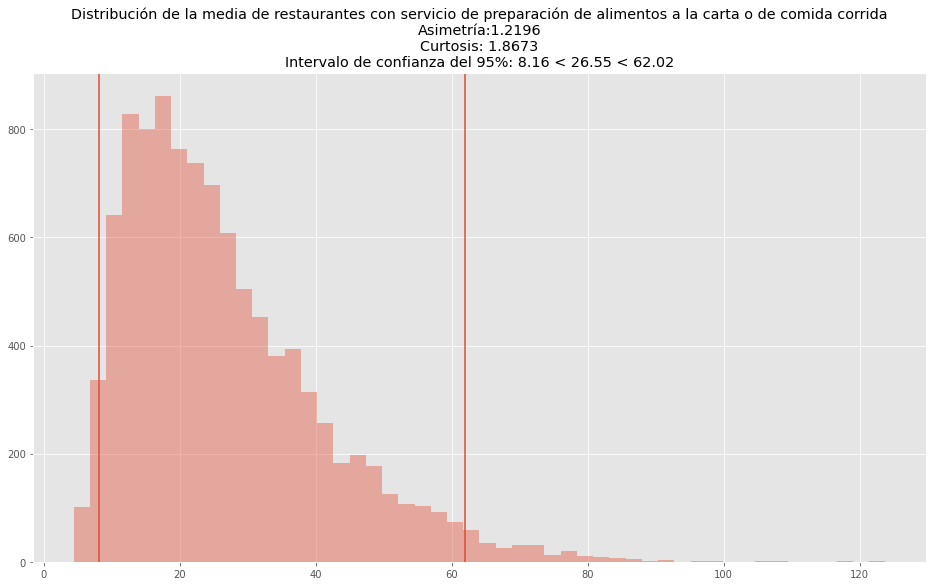

In [128]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes con servicio de preparación de alimentos a la carta o de comida corrida\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}\nIntervalo de confianza del 95%: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}');

#### Restaurantes con servicio de preparación de antojitos

In [129]:
rest_antojitos = df['antojitos']

means = []

for i in range(100_000):
    sample = rest_antojitos.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [130]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 22.48 < 26.55 < 114.0
Asimetría:1.0076
Curtosis: 1.291


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



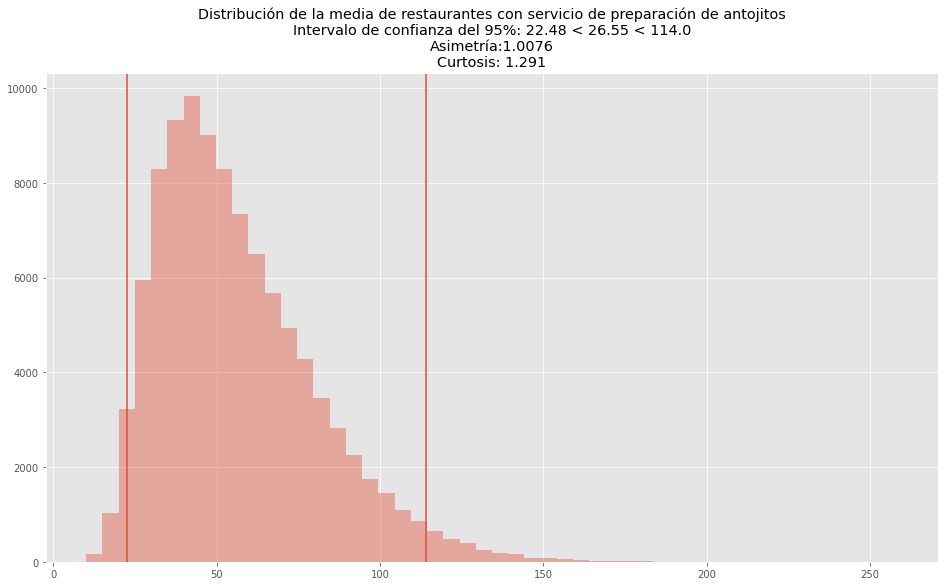

In [131]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes con servicio de preparación de antojitos\nIntervalo de confianza del 95%: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}');

#### Restaurantes con servicio de preparación de pescados y mariscos

In [132]:
rest_pesc = df['pescados_mariscos']

means = []

for i in range(100_000):
    sample = rest_pesc.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [133]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 3.04 < 26.55 < 22.08
Asimetría:1.0598
Curtosis: 1.4243


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



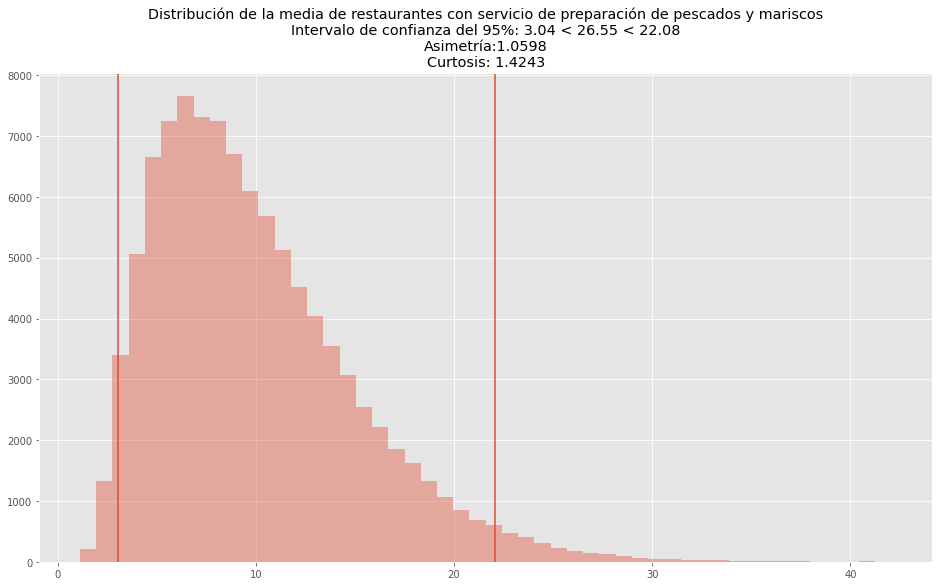

In [134]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes con servicio de preparación de pescados y mariscos\nIntervalo de confianza del 95%: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}');

#### Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar	

In [135]:
rest_rapida = df['pizzas_hamburguesas_hotdogs_pollos_rostizados']
means = []

for i in range(100_000):
    sample = rest_rapida.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [136]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 10.86 < 26.55 < 55.7
Asimetría:0.9554
Curtosis: 1.1417


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



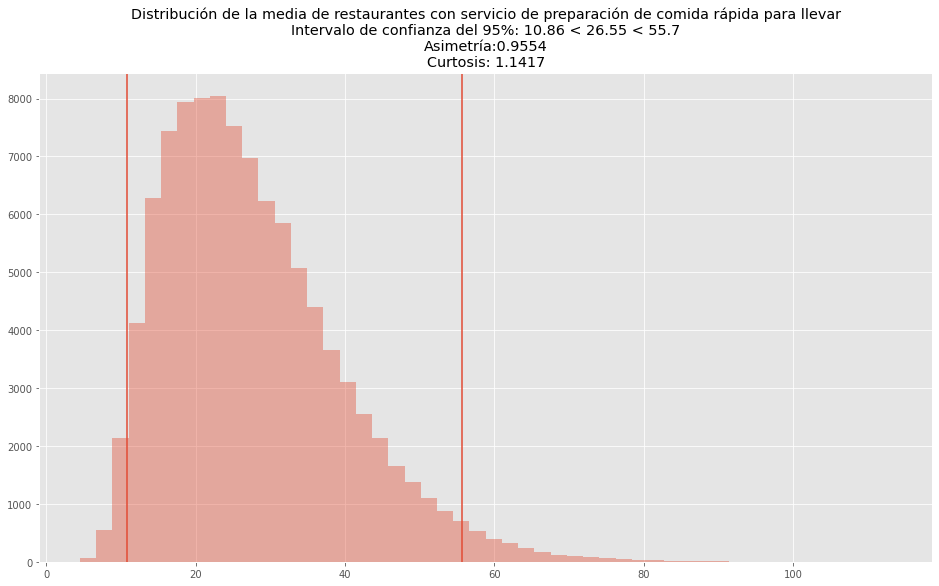

In [137]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes con servicio de preparación de comida rápida para llevar\nIntervalo de confianza del 95%: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}');

#### Restaurantes con servicio de preparación de tacos y tortas

In [138]:
rest_tacos = df['tacos_tortas']

means = []

for i in range(100_000):
    sample = rest_tacos.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [139]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 20.86 < 26.55 < 117.1
Asimetría:1.1795
Curtosis: 2.0344


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



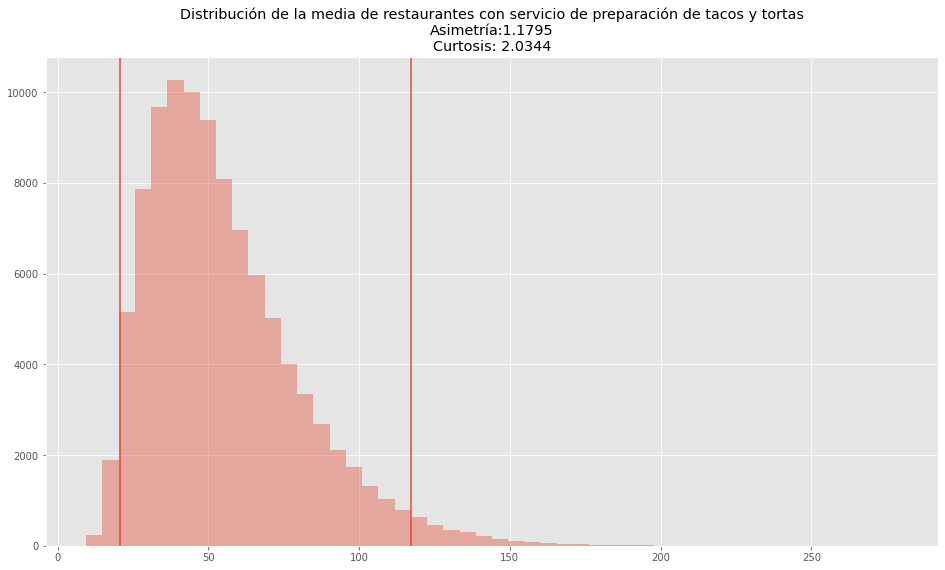

In [140]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes con servicio de preparación de tacos y tortas\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}');

#### Restaurantes de autoservicio

In [141]:
rest_auto = df['autoservicio']

means = []

for i in range(100_000):
    sample = rest_auto.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [142]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 0.68 < 26.55 < 10.72
Asimetría:1.2092
Curtosis: 1.8377


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



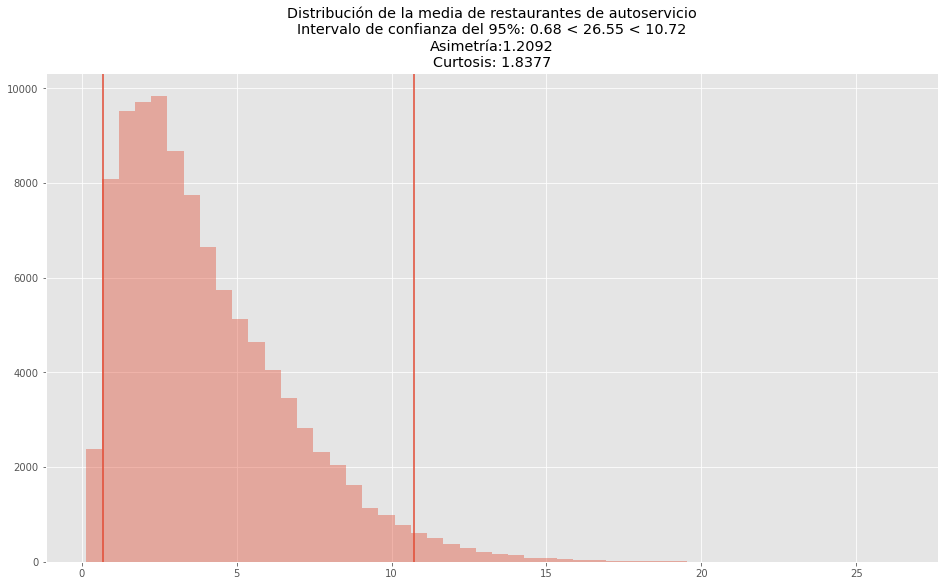

In [143]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes de autoservicio\nIntervalo de confianza del 95%: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}');

#### Restaurantes que preparan otro tipo de alimentos para llevar

In [144]:
rest_otro = df['otro_tipo_alimentos']

means = []

for i in range(100_000):
    sample = rest_otro.sample(n=50, replace=True)
    means.append(sample.mean())
    
serie_means = pd.Series(means)

In [145]:
# Asimetría, curtosis e intervalo de confianza
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

print(f'Intervalo de confianza del 95% de la media: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}')
print(f'Asimetría:{round(serie_means.skew(), 4)}')
print(f'Curtosis: {round(serie_means.kurtosis(), 4)}')

Intervalo de confianza del 95% de la media: 8.36 < 26.55 < 59.4
Asimetría:1.3077
Curtosis: 2.2211


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



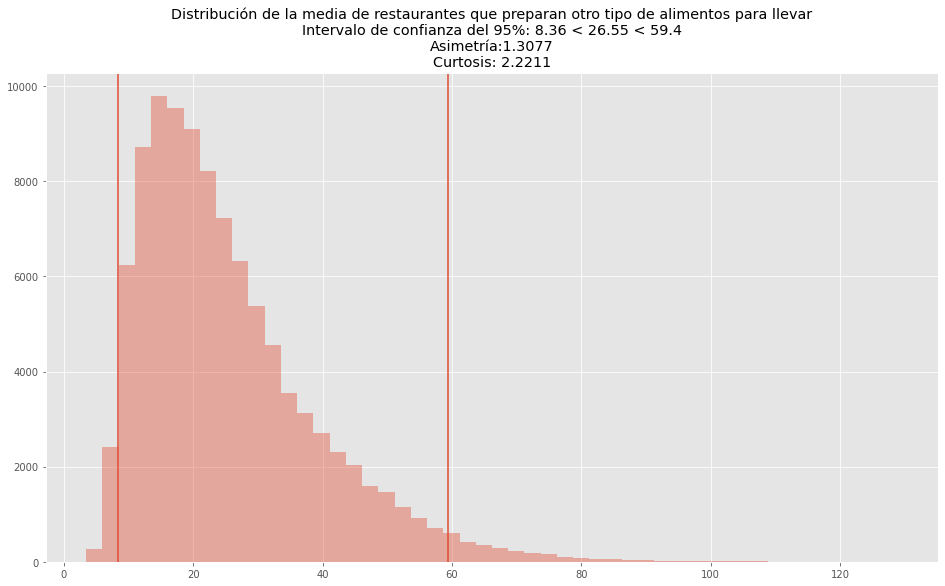

In [146]:
ax = sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior)
ax.set_title(f'Distribución de la media de restaurantes que preparan otro tipo de alimentos para llevar\nIntervalo de confianza del 95%: {round(limite_inferior, 2)} < {round(rest_carta.mean(), 2)} < {round(limite_superior, 2)}\nAsimetría:{round(serie_means.skew(), 4)}\nCurtosis: {round(serie_means.kurtosis(), 4)}');

### 3. Si tiene sentido, elige algunas de tus variables numéricas para entrenar uno o más modelos de Regresión Lineal Múltiple. Utiliza las técnicas de división de dataset y validación cruzada de K-iteraciones para asegurarte de que tu modelo generalice.

In [147]:
''' 
Para hacer la regresión se utilizarán como variables independientes las variables de población total e ingreso laboral promedio, 
y como dependiente el total de restaurantes.
'''
df_lr = pd.DataFrame()
df_lr['total_restaurantes'] = df['pescados_mariscos'] +	df['pizzas_hamburguesas_hotdogs_pollos_rostizados'] + df['tacos_tortas'] +	df['autoservicio'] +	df['otro_tipo_alimentos']
df_lr['ing_lab'] = df['ing_lab']
df_lr['pobtot'] = df['pobtot']

In [148]:
'''
Sólo se tomará en cuenta a los registros con ingresos laborales mayores a cero
'''
df_lr = df_lr[df_lr['ing_lab'] > 0]

In [149]:
df_lr

total_restaurantes  ing_lab    pobtot
2                 2178.0  7676.46  877190.0
3                   56.0  5863.52   46464.0
4                   94.0  5784.97   56048.0
5                   17.0  6096.05   15577.0
6                  266.0  6262.18  120405.0
...                  ...      ...       ...
2489                29.0  6558.72   18745.0
2490                20.0  3762.57   13099.0
2491                21.0  1877.31   19155.0
2493               440.0  7421.03  146147.0
2494                22.0  6537.04   19413.0

[928 rows x 3 columns]

In [150]:
# Ahora procedemos a realizar el modelo de regresión lineal con nuestras variables
from sklearn.model_selection import train_test_split

In [151]:
X = df_lr[['pobtot', 'ing_lab']]
y = df_lr['total_restaurantes']

X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [152]:
from sklearn.linear_model import LinearRegression

In [153]:
lr = LinearRegression()
lr.fit(X_training, y_training)
print(f'Score del modelo: {lr.score(X_test, y_test):.4f}')

Score del modelo: 0.8928


In [154]:
lr_2 = LinearRegression()
lr_2.fit(X, y)
print(f'Score del modelo sin hacer la división de entrenamiento y prueba: {lr_2.score(X, y):.4f}')

Score del modelo sin hacer la división de entrenamiento y prueba: 0.8943


In [155]:
from sklearn.model_selection import cross_validate

In [156]:
scores = cross_validate(lr, X, y, scoring='r2')
print(f'Score del modelo con validación cruzada de K-Iteraciones: {scores["test_score"].mean():.4f} +/- {scores["test_score"].std():.4f}')

Score del modelo con validación cruzada de K-Iteraciones: 0.8732 +/- 0.0480


In [157]:
'''
También se correrá una regresión con solamente la población total como variable dependiente y el total de restaurantes como independiente, 
ya que como se vio anteriormente el la correlación entre el número de restaurantes y el ingreso laboral es positivamente débil. 
'''
X = df_lr[['pobtot']]
y = df_lr['total_restaurantes']

X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [158]:
lr = LinearRegression()
lr.fit(X_training, y_training)
print(f'Score del modelo: {lr.score(X_test, y_test):.4f}')

Score del modelo: 0.8635


In [159]:
lr_2 = LinearRegression()
lr_2.fit(X, y)
print(f'Score del modelo sin hacer la división de entrenamiento y prueba: {lr_2.score(X, y):.4f}')

Score del modelo sin hacer la división de entrenamiento y prueba: 0.8937


In [160]:
scores = cross_validate(lr, X, y, scoring='r2')
print(f'Score del modelo con validación cruzada de K-Iteraciones: {scores["test_score"].mean():.4f} +/- {scores["test_score"].std():.4f}')

Score del modelo con validación cruzada de K-Iteraciones: 0.8734 +/- 0.0489


Como se puede notar, la variable de ingreso laboral no genera un gran aumento del R^2, pues pasa de 0.8943 a 0.8937 cuando esta variable no se toma en cuenta.

## **6. Visualización de Datos Avanzada**

En esta sesión conocimos muchos nuevos tipos de gráficas que nos ayudan a explorar y entender con más detalle nuestros datos. Ojalá y hayas percibido el poder tan grande que tienen las visualizaciones y la variedad tan enorme que existe. Cada visualización tiene sus ventajas y desventajas, sus características específicas, y es importante conocerlas bien para poder elegir la gráfica adecuada para cada momento. Revisa con detenimiento si hay alguna buena razón para utilizar en tu proyecto alguna de las gráficas que aprendimos hoy. 

Aquí hay un pequeño 'cheat sheet' para tomar estas decisiones:

1. Si hay relaciones jerárquicas que quieras hacer claras o si quieres explorar las proporciones de una variable numérica agrupada en múltiples niveles utiliza un treemap.
2. Si quieres explorar la relación entre dos variables numéricas divididas por una variable categórica, utiliza scatterplots por categorías o scatterplots con variables condicionantes.
3. Si quieres explorar la relación entre dos variables numéricas pero tu dataset es tan grande que es imposible definir las densidades de tus datos, utiliza un binning hexagonal.
4. Si quieres explorar datos geográficos, como definir regiones o puntos en un mapa o visualizar una variable numérica que puede segmentarse por regiones geográficas, utiliza un mapa cloroplético.
5. Si quieres explorar una variable numérica agrupada en dos niveles por variables categóricas, utiliza una gráfica de barras apiladas.

Integración de los datos geoespaciales haciendo uso del atributo caracter **CVEGEO**. 

In [161]:
municipios_merge = pd.merge(mun_geo, dataframe, left_on = ['CVEGEO'], right_on = ['CVEGEO'], how = 'left')
municipios_merge.head(5)

CVEGEO CVE_ENT CVE_MUN  ... tacos_tortas  autoservicio  otro_tipo_alimentos
0  01001      01     001  ...       1046.0          96.0                338.0
1  01002      01     002  ...         37.0           0.0                  5.0
2  01003      01     003  ...         58.0           2.0                  4.0
3  01004      01     004  ...         10.0           0.0                  2.0
4  01005      01     005  ...        154.0           3.0                 28.0

[5 rows x 36 columns]

Validación de los polígonos, se desagregado el color por el total de población.

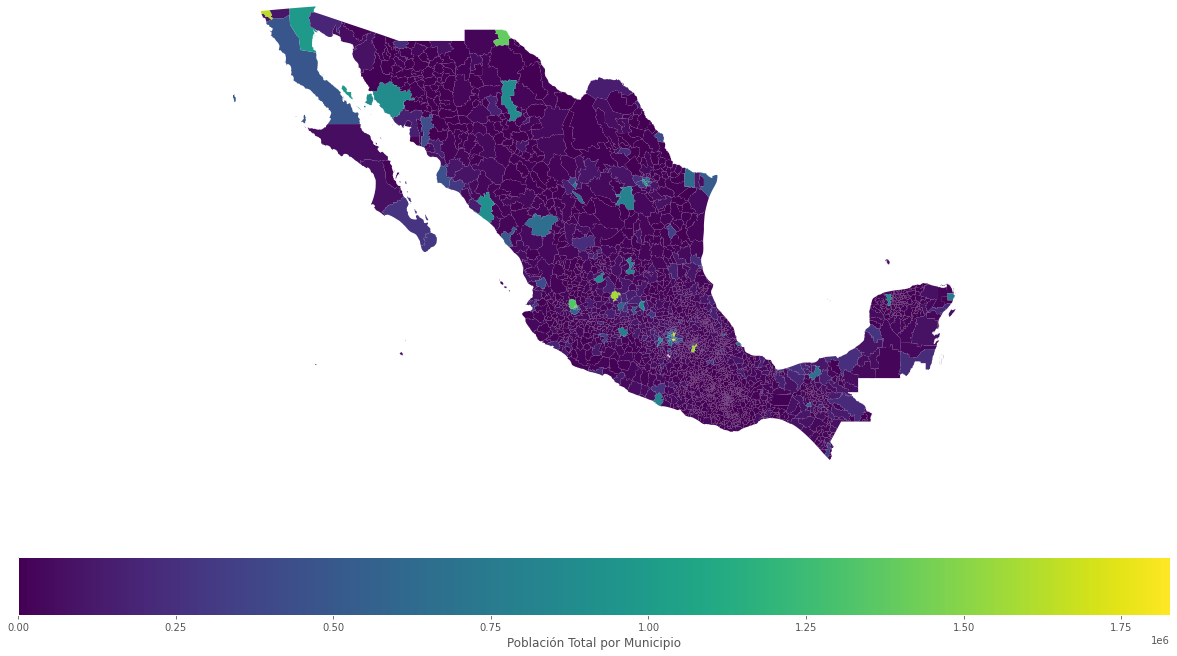

In [162]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

municipios_merge.plot(ax=ax, column='pobtot', legend=True, legend_kwds={'label': "Población Total por Municipio", 
                                                                        'orientation': "horizontal"})
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

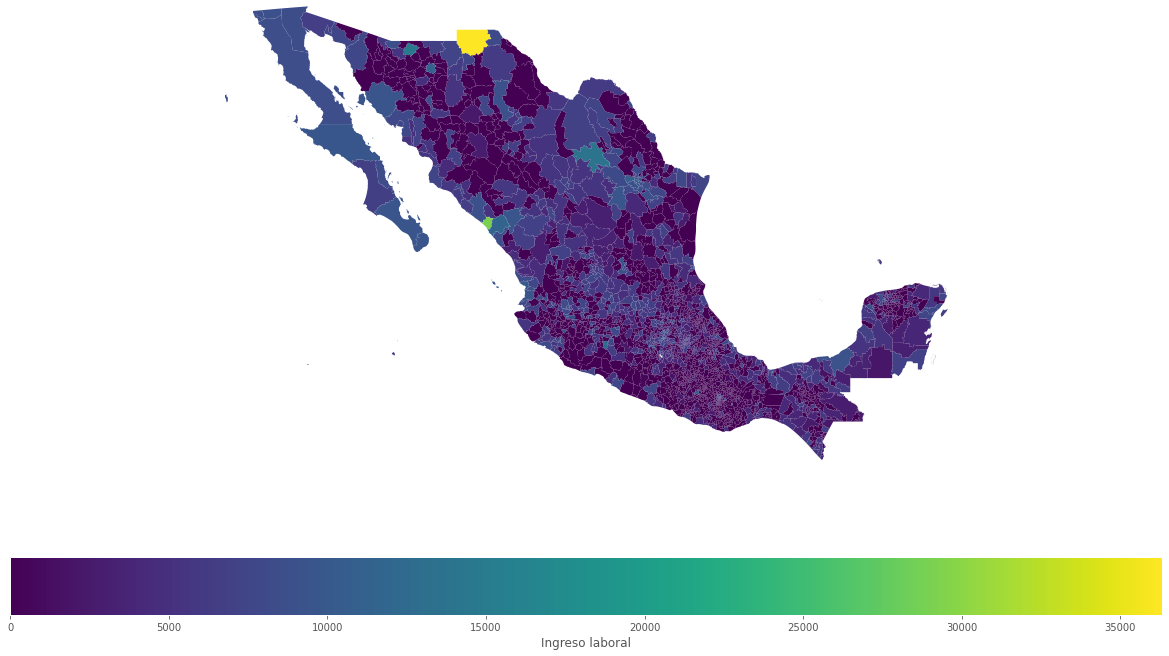

In [163]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

municipios_merge.plot(ax=ax, column='ing_lab', legend=True, legend_kwds={'label': "Ingreso laboral", 
                                                                        'orientation': "horizontal"})
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

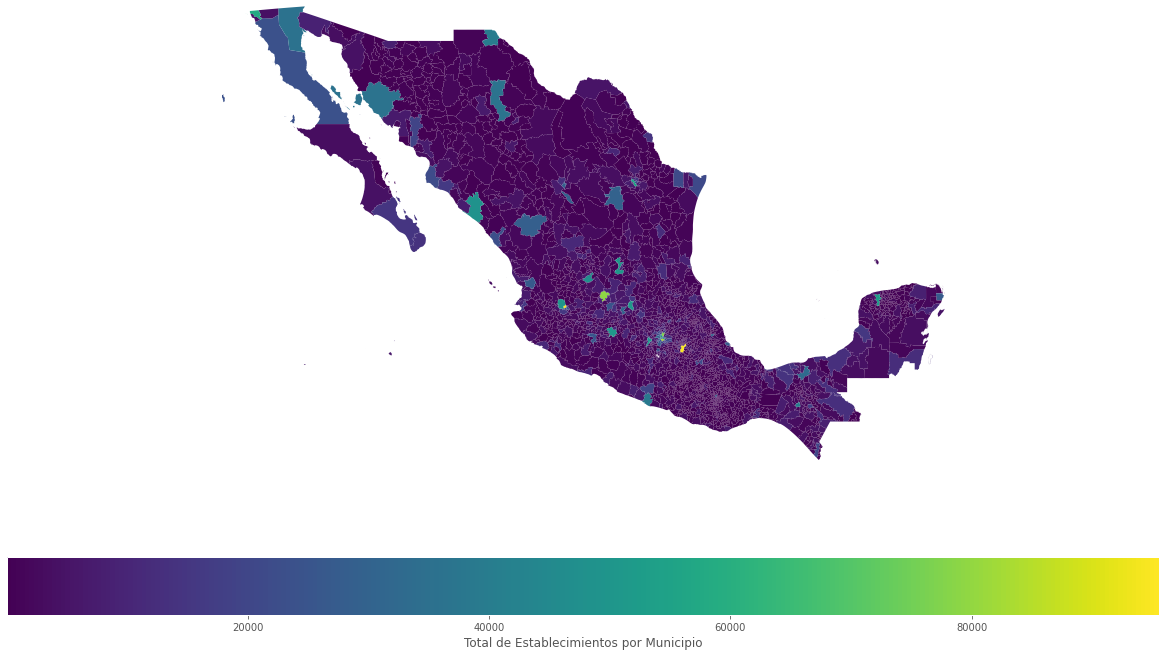

In [164]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

municipios_merge.plot(ax=ax, column='tot_est', legend=True, legend_kwds={'label': "Total de Establecimientos por Municipio", 
                                                                        'orientation': "horizontal"})
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

## **7. Procesamiento de Lenguaje Natural**
En esta sesión aprendimos dos cosas: Pruebas A/B y Procesamiento de Lenguaje Natural. No podemos practicar Pruebas A/B en nuestro proyecto, porque en realidad los proyectos que estamos realizando no se prestan a esto. No pasa nada, ¡ya tendrás oportunidad de practicar eso en tu primer trabajo como científico de datos!

Por lo pronto en este Postwork vamos a practicar las técnicas de Procesamiento de Lenguaje Natural que hemos aprendido. Si tu dataset no contiene datos no estructurados, busca un dataset apropiado y realiza los siguientes ejercicios. Si tu dataset contiene datos no estructurados, entonces éste es el momento de agregar PLN a tu proyecto.

Realiza los siguientes procedimientos en caso de que apliquen a tu dataset:

1. Utiliza patrones Regex para limpiar tus datos estructurados
2. Dado que debes de conocer bien tu dataset (excepto si es un nuevo dataset que buscaste para este Postwork), es probable que tengas una idea de las palabras que son relevantes para tu tema. Genera un objeto Text con la librería nltk y explora los contextos de las palabras que elegiste. Utiliza el método similar para obtener palabras que tengan contextos similares a las palabras originales. Puede que descubras nuevas palabras que tengan relevancia para tu proyecto.
3. Utiliza el objeto FreqDist de nltk para hacer análisis estadístico de tu dataset. Explora las palabras y los bigramas más comunes de tu dataset.
4. Realiza visualizaciones de tus conteos de frecuencias utilizando gráficas de barras.
5. Realiza visualizaciones de las distribuciones de frecuencias de las longitudes de las palabras o de las oraciones.
6. Realiza nubes de palabras para detectar los temas más importantes de tu conjunto de datos.
7. Haz un análisis de sentimientos de tu conjunto de datos, de preferencia utilizando una variable categórica para segmentar tus datos y poder comparar las distribuciones de polaridades entre cada segmento.

Utilizamos nuestro conjunto de datos del modulo anterior, el cual se extrajó con web scraping sobre las notas periodísticas que mencionaban *restaurantes* y *covid* para aplicar los conocientos adquiridos durante esta sesión. 

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/Python/data/jornada_restaurantes.csv')
data

author  ...                                              title
0                                 Redacción  ...  2020: Un año donde la diferencia la hicimos to...
1              Héctor Briseño, Corresponsal  ...  Cayó $3 mil millones la derrama turística dece...
2                                       Afp  ...  Inglaterra mantendrá importantes restricciones...
3                         Afp, Ap y Sputnik  ...  Millón y medio de infectados en América en una...
4                   Rocío González Alvarado  ...   "Alerta al límite del rojo" en la CDMX: Shein...
..                                      ...  ...                                                ...
639         Néstor Jiménez y Alonso Urrutia  ...  Multas de hasta 3 mdp por alzas irregulares en...
640  Carlos Águila Arreola/ La Jornada Maya  ...  Cancún cerrará todo giro comercial para evitar...
641              Lilián Anaya @Lilian_Anaya  ...  Uber Eats apoya a restaurantes, repartidores y...
642                                      Ap  ...  Desembarcan en Cuba pasajeros de crucero recha...
643             Israel Dávila, corresponsal  ...  También en el Edomex cierran establecimientos ...

[644 rows x 8 columns]

Se reemplazan los textos referentes a los meses al idioma inglés, para que el parser del módulo dateutil reconozca la fecha en el texto de manera automática y se pueda convertir el string a un formato datetime.

In [ ]:
data['date'] = data['date'].str.replace(r'ago', 'aug')
data['date'] = data['date'].str.replace(r'abr', 'apr')
data['date'] = data['date'].str.replace(r'ene', 'jan')
data['date'] = data['date'].str.replace(r'dic', 'dec')
data['date'] = [dateutil.parser.parse(x, fuzzy_with_tokens=True)[0] for x in data['date']]
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month

Se concatena todo el texto de las noticias por mes para aplicar regex y generar las nubes de palabras por mes.

In [ ]:
data_month = data.groupby(['month'])['body'].apply(' '.join).reset_index()
data_month = data_month.set_index('month')
data_month

body
month                                                   
1      Acapulco, Gro., Los principales destinos turís...
2      Seúl. Corea del Norte anunció un arsenal de me...
3      Mérida, Yuc. Para disminuir en todo lo posible...
4      Teotihuacán, Méx. Un grupo de comerciantes y a...
5      Berlín. Alemania prolongará hasta el 29 de jun...
6      Ciudad de México. De los 121 mil 765 estableci...
7      Lima. El gobierno peruano informó este miércol...
8      Londres. Las medidas para evitar la propagació...
9      Ciudad de México. Dirigentes de asociaciones d...
10     Bruselas. Bélgica impondrá reglas de confinami...
11     Londres. La totalidad de los 56 millones de ha...
12     México, como muchos países está volviendo a re...

Se aplican expresiones regulares para limpiar los textos, principalmente se remueven signos de puntuación, espacios extras y tabulaciones.



In [ ]:
def clean_text_round1(text):
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
 
round1 = lambda x: clean_text_round1(x)
 
data_clean = pd.DataFrame(data_month.body.apply(round1))

def clean_text_round2(text):
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text
 
round2 = lambda x: clean_text_round2(x)
 
data_clean = pd.DataFrame(data_clean.body.apply(round2))
data_clean

body
month                                                   
1      acapulco  gro   los principales destinos turís...
2      seúl  corea del norte anunció un arsenal de me...
3      mérida  yuc  para disminuir en todo lo posible...
4      teotihuacán  méx  un grupo de comerciantes y a...
5      berlín  alemania prolongará hasta el  de junio...
6      ciudad de méxico  de los  mil  establecimiento...
7      lima  el gobierno peruano informó este miércol...
8      londres  las medidas para evitar la propagació...
9      ciudad de méxico  dirigentes de asociaciones d...
10     bruselas  bélgica impondrá reglas de confinami...
11     londres  la totalidad de los  millones de habi...
12     méxico  como muchos países está volviendo a re...

A partir del conjunto de datos limpio, se crea un "Bag of Words" contando el número de veces que una palabra aparece en las noticias y calculando la frecuencia de las mismas. En este paso, se incluye la lectura de las "stopwords" en español desde nuestro repositorio, las cuales nos permiten filtrar palabras vacías o sin significado para nuestro análisis como artículos, pronombres, preposiciones, etc.

In [ ]:
import base64
import requests

master = "https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/Python/data/spanish.txt"
req = requests.get(master)
lines = req.text.split(sep='\n')

In [ ]:
cv = CountVectorizer(stop_words=lines)
data_cv = cv.fit_transform(data_clean.body)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
 
data_dtm

abad  abajo  abandonados  abandonando  ...  𝐝𝐞𝐥  𝐥𝐚  𝐩𝐚𝐫𝐚  𝐬𝐭𝐢𝐜𝐨
month                                         ...                      
1         0      0            0            0  ...    0   0     0      0
2         0      0            0            0  ...    0   0     0      0
3         0      0            1            0  ...    0   0     0      0
4         0      0            1            0  ...    0   0     0      0
5         1      0            0            0  ...    1   1     1      1
6         0      2            0            0  ...    0   0     0      0
7         0      1            0            0  ...    0   0     0      0
8         0      0            0            1  ...    0   0     0      0
9         0      0            0            0  ...    0   0     0      0
10        0      0            0            0  ...    0   0     0      0
11        0      0            0            0  ...    0   0     0      0
12        0      0            0            0  ...    0   0     0      0

[12 rows x 19604 columns]

In [ ]:
dt_data = data_dtm.transpose()
dt_data.head()

month        1   2   3   4   5   6   7   8   9   10  11  12
abad          0   0   0   0   1   0   0   0   0   0   0   0
abajo         0   0   0   0   0   2   1   0   0   0   0   0
abandonados   0   0   1   1   0   0   0   0   0   0   0   0
abandonando   0   0   0   0   0   0   0   1   0   0   0   0
abandonar     0   0   1   1   1   2   1   0   0   0   1   0

Se extraen las palabras más usadas por meses, identificando las palabras como covid y sus sinónimos, restaurantes, restricciones, apoyos, estas palabras forman parte de la conversación habitual en las notas periodisticas sobre los restaurantes.

In [ ]:
top_dict = {}
for c in dt_data.columns:
    top = dt_data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

for month, top_words in top_dict.items():
    print(month)
    print(', '.join([word+' '+str(count) for word, count in top_words[0:14]]))

1
mil 18, ciento 10, millones 9, pesos 9, acapulco 8, turismo 8, ocupación 7, año 7, derrama 6, playas 5, turistas 5, presidente 4, debido 4, promedio 3
2
coronavirus 10, país 9, irán 6, países 6, casos 6, corea 6, irak 5, ahora 5, según 5, saudita 5, hadj 5, año 5, norte 5, china 5
3
mil 237, covid 182, país 159, medidas 152, personas 147, restaurantes 147, gobierno 141, ciudad 139, méxico 130, salud 128, coronavirus 115, casos 112, ciento 108, pandemia 88
4
mil 179, covid 115, personas 96, pandemia 90, gobierno 88, millones 86, restaurantes 82, salud 79, país 79, coronavirus 77, méxico 73, medidas 71, ciudad 63, ciento 63
5
mil 454, covid 236, coronavirus 221, pandemia 192, ciento 166, millones 144, país 144, dos 141, restaurantes 140, personas 130, medidas 124, muertos 122, mayo 121, gobierno 119
6
ciento 242, mil 236, covid 149, restaurantes 132, casos 117, medidas 115, méxico 109, actividades 109, pandemia 104, personas 104, coronavirus 95, dijo 93, semáforo 90, ciudad 82
7
mil 19

Dentro de este listado se observa que hay varias palabras muy usadas sin un significado útil para el análisis. Por lo que se procede a crear una lista de las palabras menos usadas, para posteriormente unificarlo a nuestro listado de stopwords.

In [ ]:
from collections import Counter

words = []
for anio in dt_data.columns:
    top = [word for (word, count) in top_dict[anio]]
    for t in top:
        words.append(t)
print(Counter(words).most_common())
add_stop_words = [word for word, count in Counter(words).most_common() if count > 6]
add_stop_words

[('mil', 11), ('millones', 11), ('covid', 11), ('país', 11), ('ciento', 10), ('pandemia', 10), ('casos', 10), ('personas', 10), ('méxico', 10), ('coronavirus', 9), ('medidas', 9), ('restaurantes', 9), ('gobierno', 9), ('ciudad', 9), ('salud', 9), ('contagios', 8), ('número', 6), ('dijo', 6), ('actividades', 6), ('parte', 5), ('si', 5), ('según', 5), ('turismo', 4), ('año', 4), ('restricciones', 4), ('días', 4), ('semana', 4), ('dos', 4), ('autoridades', 3), ('cierre', 3), ('así', 3), ('mientras', 3), ('sector', 3), ('menos', 3), ('lunes', 3), ('turistas', 2), ('debido', 2), ('económica', 2), ('países', 2), ('centros', 2), ('virus', 2), ('servicios', 2), ('crisis', 2), ('empresas', 2), ('meses', 2), ('mundo', 2), ('europa', 2), ('reapertura', 2), ('negocios', 2), ('mayor', 2), ('horas', 2), ('bares', 2), ('confinamiento', 2), ('pesos', 1), ('acapulco', 1), ('ocupación', 1), ('derrama', 1), ('playas', 1), ('presidente', 1), ('promedio', 1), ('guerrero', 1), ('informó', 1), ('diciembre', 

['mil',
 'millones',
 'covid',
 'país',
 'ciento',
 'pandemia',
 'casos',
 'personas',
 'méxico',
 'coronavirus',
 'medidas',
 'restaurantes',
 'gobierno',
 'ciudad',
 'salud',
 'contagios']

Se actualiza la "Bag of Words" que se quitaran del conjunto de datos. Algunas de ellas se pueden incorporar manualmente a la lista.

In [ ]:
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

stop_words = req.text.split(sep='\n')
for pal in add_stop_words:
    stop_words.append(pal)
more_stop_words=['día','nuevo','según','si','hora','año','function', 'recomendamos', 'west', 'texas', 'wti', 'además', 'intermediate', 'display','ad','gpt','dijo','div','más','también', 'interarticle','pues','parte','está', 'cmd', 'push', 'googletag','alex','lucas','andrés','mirta','tres','primer','primera','dos','uno','veces', 'así', 'luego', 'quizá','cosa','cosas','tan','asi','andres','todas','sólo','jesús','pablo','pepe']
for pal in more_stop_words:
    stop_words.append(pal)

cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.body)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

## **Nubes de palabras por mes**

Se generan nubes de palabras para identificar los topicos principales por meses. Observando que en el mes de Julio, se mencionó varias veces la reapertura de servicios de comida en varias regiones del país.

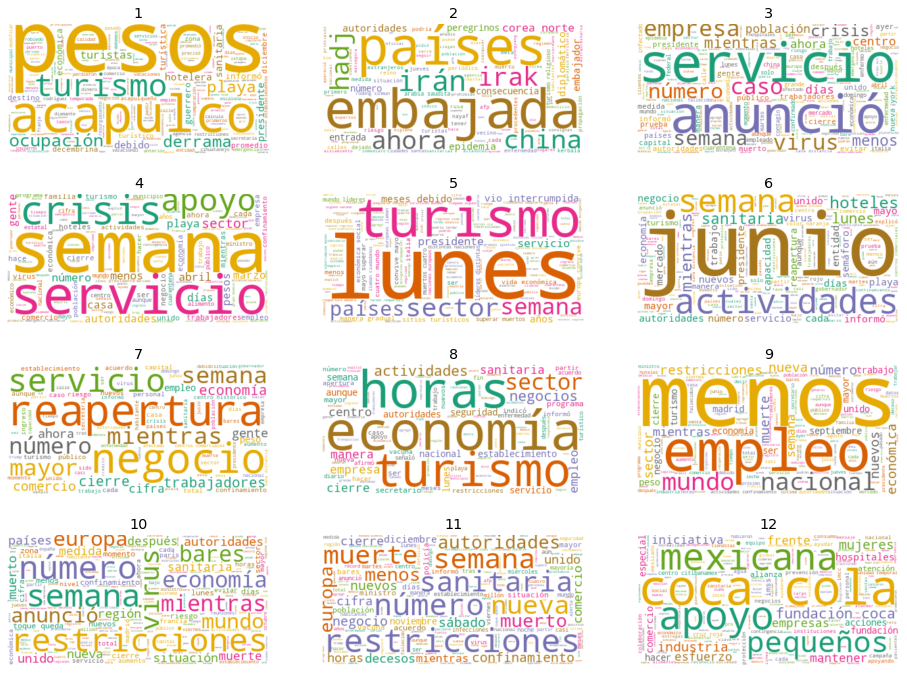

In [ ]:
from wordcloud import WordCloud
anios = ['1','2','3','4','5','6','7','8','9','10','11','12']

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,12]

for index, mes in enumerate(dt_data.columns):
    wc.generate(data_clean.body[mes])
    plt.subplot(4, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(anios[index])
plt.show()

## **8. Clasificación No Supervisada y Supervisada**

En este Postwork haremos dos cosas: practicar la aplicación del algoritmo de Regresión Logística y resolver dudas generales sobre tu proyecto. Realiza los siguientes pasos:

1. Si hay un problema de clasificación binaria en tu proyecto, ¡genial! Aplica lo aprendido en esta sesión y entrena un modelo de Regresión Logística con tu dataset.
2. Si no hay un problema de clasificación binaria en tu proyecto, pídele ayuda a la experta para conseguir un dataset con el que puedas practicar.
3. Evalúa tu modelo de Regresión Logística utilizando matriz de confusión; medidas de precisión, exactitud, sensibilidad y especificidad; y curva ROC / AUC.
> Ojo: si tu proyecto tiene un problema de clasificación multiclase (es decir, la variable dependiente no es binaria sino que contiene más de 2 categorías posibles), pídele ayuda a la experta para aplicar el algoritmo de Regresión Logística Multiclase.



## **Normalización de los datos**

Para ayudar a nuestro algoritmo K-Means en la interpretación de características con diferentes magnitudes y distribuciones, se normalizaron los datos y  se aplicó PCA (Principal Component Analysis) para reducir dimensiones del espacio de características original, debido a que nos cuestionamos ¿cuáles atributos deberíamos elegir para obtener buenas predicciones o agrupamientos, sin perder información valiosa?  

In [165]:
scaler=StandardScaler()
df = dataframe.drop(['imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO','pob','tra_omun','ocupados','desocupados'], axis=1)
scaler.fit(df) # Calcula la media y estandar para cada dimensión
X_scaled=scaler.transform(df) # Transforma los datos a su nueva escala

In [166]:
X_scaled

array([[ 5.96660941,  1.86140909,  5.96033839, ...,  5.56910192,
         4.80058667,  3.2452995 ],
       [-0.01487984,  1.26424369, -0.08470377, ..., -0.10100787,
        -0.21091069, -0.21207187],
       [ 0.05412799,  1.23837006,  0.01672036, ...,  0.01700234,
        -0.10650449, -0.22245437],
       ...,
       [ 0.70286921,  1.77727285,  0.68561127, ...,  0.93860592,
         1.45958843,  0.1928455 ],
       [-0.20965557,  1.48609485, -0.2138412 , ..., -0.25273529,
        -0.21091069, -0.26398436],
       [-0.33031126, -0.66714469, -0.3012283 , ..., -0.28645249,
        -0.15870759, -0.26398436]])

## **Busquéda de los componentes principales con algoritmo PCA**

In [167]:
pca=PCA(n_components=5)
#pca=PCA(.85)
pca.fit(X_scaled) # Buscar los componentes principales
X_pca=pca.transform(X_scaled) 
#Se revisa la forma del array
print("shape of X_pca", X_pca.shape)

shape of X_pca (2463, 5)


De tal manera que elegir arbitrariamente las dimensiones a considerar dentro del algoritmo no supervisado, no era la opción, así que optamos por calcular la proporción de variación explicada con la cual alcanzamos a explicar 97.12% de la variabilidad total con 5 componentes. 

### **Varianza explicada**

Varianza explicada del **97%**con los componentes principales calculados en el segmento de código anterior.

In [168]:
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:5]))
# Con 5 componentes tenemos algo mas del 97% de varianza explicada

[0.85117746 0.04772137 0.03841022 0.01976435 0.01414569]
suma: 0.9712190918418963


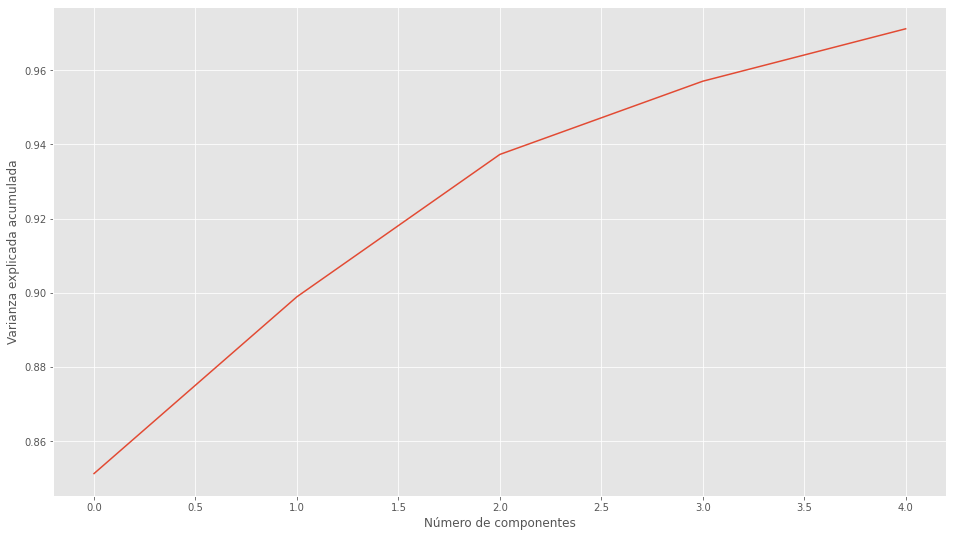

In [169]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.show()

No handles with labels found to put in legend.


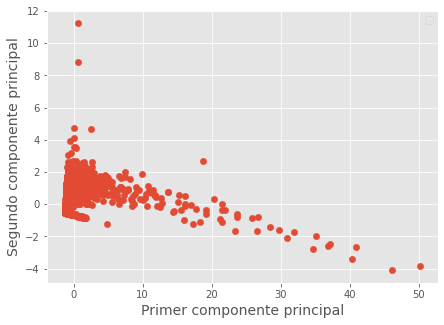

In [170]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')

ax.scatter(Xax,Yax,s=40)

plt.xlabel("Primer componente principal",fontsize=14)
plt.ylabel("Segundo componente principal",fontsize=14)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



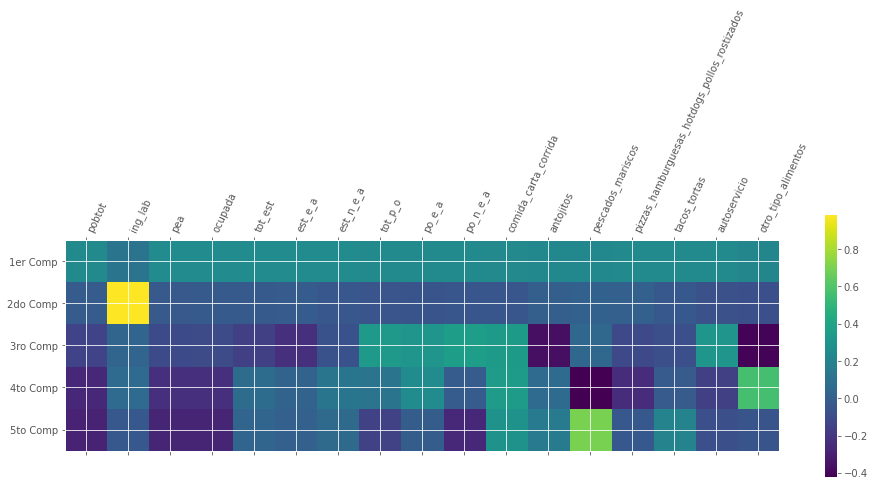

In [171]:
plt.matshow(pca.components_[0:5],cmap='viridis')
plt.yticks([0,1,2,3,4],['1er Comp','2do Comp','3ro Comp','4to Comp','5to Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(df.columns)),df.columns,rotation=65,ha='left')
plt.tight_layout()
plt.show()# 

In [172]:
components = pd.DataFrame(pca.components_, columns = df.columns)
components.shape

(5, 17)

## **Algoritmo K-MEANS**

Después de deshacernos de los autovectores de menor importancia relativa, se identificó el número óptimo de grupos a definir en nuestro algoritmo K-means. Se utilizó la distancia media al centroide en función de k y se encontró el punto codo donde la tasa de descenso se quiebra o se afila.

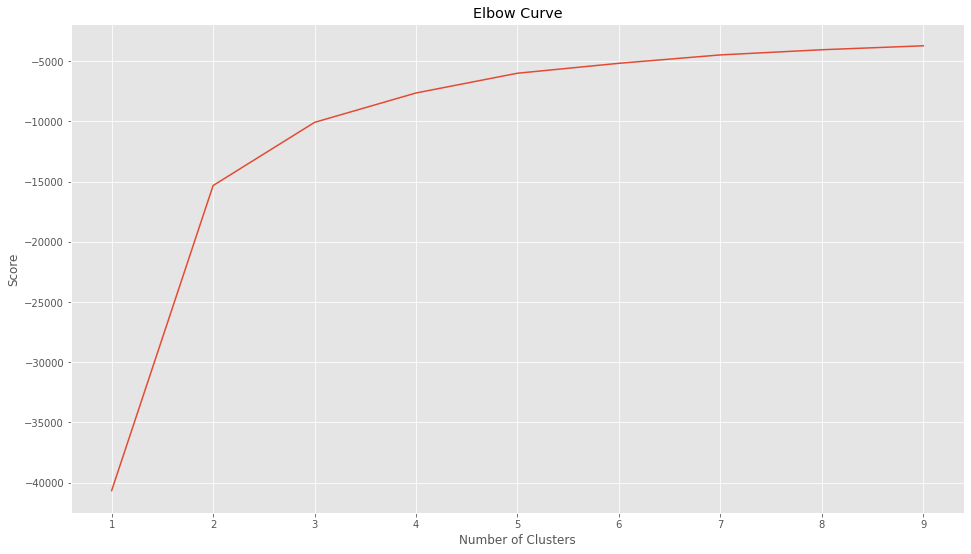

In [180]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_pca).score(X_pca) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

A nuestro criterio y con la gráfica de la curva de codo, se consideró que 3 era buen número para el valor K. Ejecutamos el algoritmo para 3 clusters, y graficamos con colores los grupos para ver si se lograban diferenciar entre ellos presentando una buena separación y compactación.  

In [174]:
# Para el proyecto, se eligio el valor 3 como un buen valor de K. Pero podría ser otro.
kmeans = KMeans(n_clusters=3).fit(X_pca)
centroids = kmeans.cluster_centers_
print(centroids)

[[-6.46375082e-01 -3.66806251e-03  9.78145660e-03  6.86059939e-03
   1.59322490e-03]
 [ 9.79847842e+00  5.85875528e-01 -4.97772707e-01 -1.97378051e-01
  -1.50834693e-02]
 [ 3.00012849e+01 -1.64150708e+00  7.40102865e-01  6.06975263e-04
  -1.04932775e-01]]


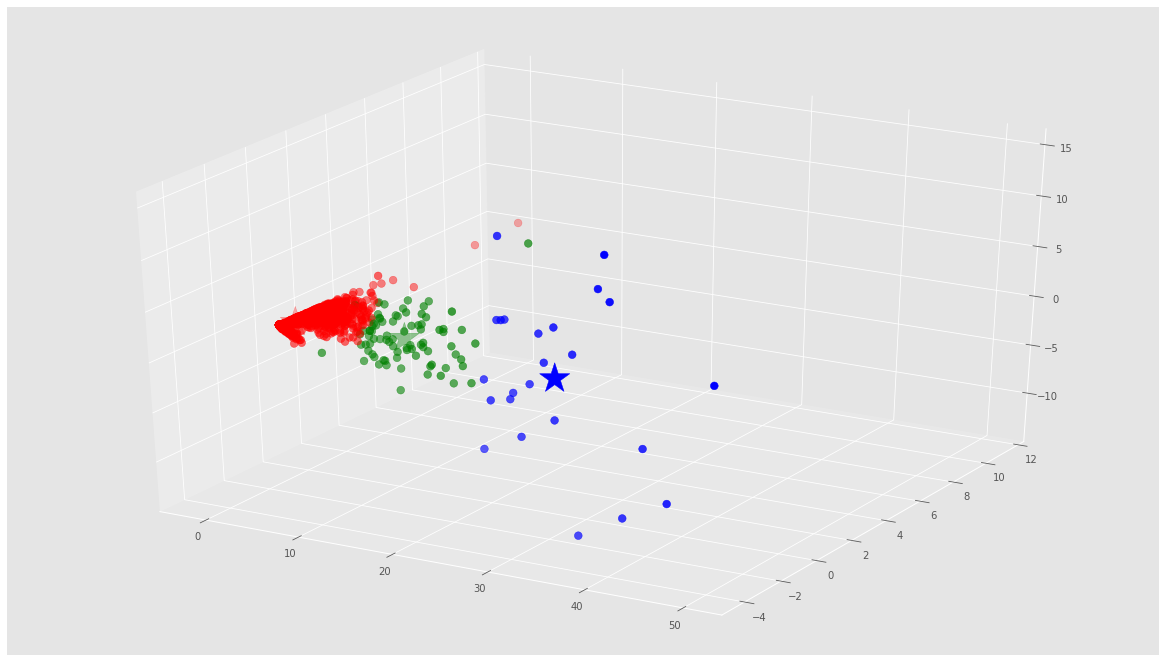

In [175]:
# Se obtienen las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X_pca)
# Se obtienen los centroids
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [176]:
# Se cuentan los usuarios que hay en cada grupo
copy =  pd.DataFrame()
copy['imun']=dataframe['imun'].values
copy['ent']=dataframe['ent'].values
copy['nom_ent']=dataframe['nom_ent'].values
copy['mun']=dataframe['mun'].values
copy['nom_mun']=dataframe['nom_mun'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

color  cantidad
0    red      2357
1  green        82
2   blue        24

In [177]:
copy.head()

imun  ent         nom_ent  mun         nom_mun  label
0  1001    1  Aguascalientes  1.0  Aguascalientes      2
1  1002    1  Aguascalientes  2.0        Asientos      0
2  1003    1  Aguascalientes  3.0        Calvillo      0
3  1004    1  Aguascalientes  4.0           Cosío      0
4  1005    1  Aguascalientes  5.0     Jesús María      0

In [178]:
column_values = ['C1','C2','C3','C4','C5']  
df_pca = pd.DataFrame(data = X_pca,    
                  columns = column_values) 

In [201]:
df_pca['CVEGEO']=dataframe['CVEGEO'].values
df_pca['imun']=dataframe['imun'].values
df_pca['ent']=dataframe['ent'].values
df_pca['nom_ent']=dataframe['nom_ent'].values
df_pca['mun']=dataframe['mun'].values
df_pca['nom_mun']=dataframe['nom_mun'].values
df_pca['label'] = labels;
df_pca['pobtot']=dataframe['pobtot'].values
df_pca['ing_lab']=dataframe['ing_lab'].values
df_pca['pea']=dataframe['pea'].values
df_pca['ocupada']=dataframe['ocupada'].values
df_pca['tot_est']=dataframe['tot_est'].values
df_pca

C1        C2        C3  ...       pea   ocupada tot_est
0     23.618205 -0.602733 -2.681271  ...  382550.0  367528.0   46426
1     -0.481234  1.331642  0.003189  ...   13914.0   13108.0     989
2      0.205075  1.239920 -0.130636  ...   20099.0   19352.0    3280
3     -0.719796  1.426835  0.105230  ...    4869.0    4627.0    1000
4      2.167316  1.175894  0.106926  ...   51020.0   49795.0    6377
...         ...       ...       ...  ...       ...       ...     ...
2458  -0.995315  0.071791  0.046283  ...    4538.0    4324.0     423
2459  -0.302566 -0.608355 -0.167471  ...    9018.0    8176.0    3532
2460   4.117187  1.286299  0.690244  ...   60889.0   58330.0    9716
2461  -0.738244  1.580330  0.076237  ...    6039.0    5703.0     665
2462  -1.216892 -0.534896  0.116456  ...     710.0     643.0     173

[2463 rows x 17 columns]

## **Interpretación de los grupos resultantes**

**Grupo 0**: el número de municipios contenidos corresponde a 2,357, los cuales presentan un bajo número del total de población, por lo mismo tienen baja población económicamente activa y bajo número de empleados. Esto conlleva que el total de establecimientos también sea bajo. Lo único favorable de este grupo es que hay ciertas regiones con altos salarios, pero este grupo dado sus características se convierte en la opción menos deseable para iniciar un negocio.

**Grupo 1**: está conformado por 82 municipios con población total, ingreso laboral, población económicamente activa, número de ocupados y total de establecimientos en rangos promedios. Es probable que se exijan alimentos baratos o con precios promedio, y su número de establecimientos también indica que existe mayor competencia culinaria. 

**Grupo 2**: están agrupados 24 municipios con altos valores en todos sus indicadores sociodemográficos, excluyendo únicamente el ingreso laboral debido a el salario de estas regiones son promedio. Aunque por la gran afluencia de la zona y el número de personas económicamente activas se puede determinar que estos municipios representan las mejores opciones para iniciar un negocio, lo único en contra es la cantidad de establecimientos que representan una competencia. 

In [202]:
mask = (df_pca.label == 2)
df_pca.loc[mask]

C1        C2         C3  ...       pea   ocupada tot_est
0     23.618205 -0.602733  -2.681271  ...  382550.0  367528.0   46426
12    21.449658 -0.333887   3.945200  ...  429396.0  411812.0   35876
14    37.193738 -2.475618  10.005532  ...  741226.0  714819.0   58150
221   21.967619 -0.370532   4.046677  ...  390819.0  377117.0   36291
239   29.792038 -1.585317   5.642669  ...  597127.0  575889.0   39929
273   26.579344 -1.675206  -5.576657  ...  521596.0  498501.0   51665
275   40.333341 -3.420337  -9.705838  ...  825520.0  786218.0   83693
283   36.904124 -2.607794  14.512567  ...  282035.0  269664.0   65185
284   20.318098  0.331888  11.346268  ...  193221.0  187477.0   24279
344   40.859865 -2.634039  -3.468821  ...  703468.0  680898.0   79402
371   21.151587 -0.887762  -1.463976  ...  331914.0  316765.0   38630
574   50.139488 -3.841167   5.344761  ...  666171.0  640805.0   95568
655   31.904550 -1.695638   3.430765  ...  599709.0  578546.0   50184
693   34.612351 -2.796993 -13.105029  ...  701545.0  662037.0   77286
718   21.564543 -1.132342  -8.168876  ...  455369.0  435543.0   50033
766   23.384691 -1.654627  -2.468511  ...  360282.0  343736.0   50758
838   23.716211 -0.805800  -3.108512  ...  335395.0  320793.0   50738
990   35.084900 -1.989264  10.490817  ...  482835.0  466408.0   55841
1686  46.120268 -4.110968  -6.549925  ...  683966.0  655995.0   94850
1803  28.425807 -1.405449   1.825578  ...  404974.0  390239.0   50975
1846  25.826136 -0.842678  -1.233031  ...  369709.0  356728.0   50118
1882  26.705119 -0.803516   3.857281  ...  378953.0  366171.0   48418
1924  21.537220  0.033435   3.675901  ...  402049.0  386978.0   36265
2348  30.841935 -2.089826  -2.831100  ...  409580.0  400697.0   52728

[24 rows x 17 columns]

In [183]:
y = df_pca['label']
X = df_pca.drop(['label','imun','ent','mun'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [184]:
mun_pca_merge = pd.merge(mun_geo, df_pca, left_on = ['CVEGEO'], right_on = ['CVEGEO'], how = 'left')

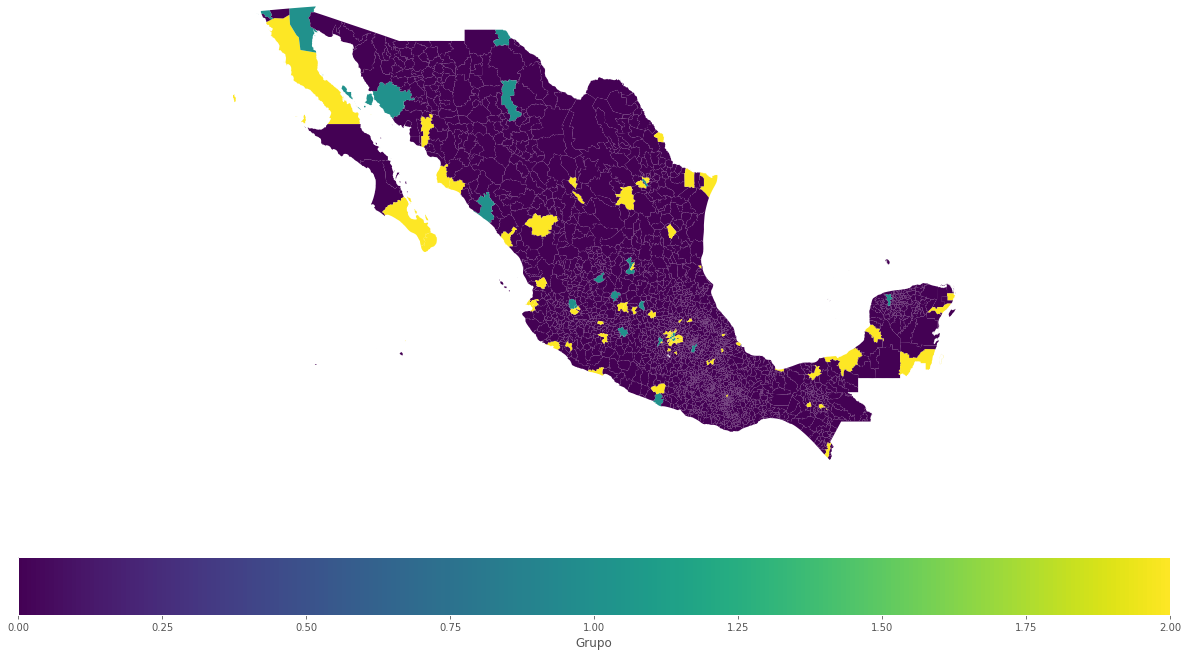

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

mun_pca_merge.plot(ax=ax, column='label', legend=True, legend_kwds={'label': "Grupo", 
                                                                        'orientation': "horizontal"})
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

In [206]:
# Grupo 0 Morado, Grupo 1 Verde, Grupo 2 Amarillo
mun_pca_merge.plot_bokeh(
    figsize=(900, 600),
    simplify_shapes=500,
    category="label",
    show_colorbar=False,
    colormap=['#440154', '#79D151', '#FDE724'],
    hovertool_columns=["nom_ent",'nom_mun', "label"],
    tile_provider="STAMEN_TERRAIN_RETINA")

Figure(id='2208', ...)

## **Validación del modelo de datos**

Para validar nuestro modelo dividimos el conjunto de datos resultantes del K-Means en un set de entrenamiento y otro pruebas, y aplicamos un modelo de regresión logística y otra de random forest para hacer las predicciones.  La matriz de confusión  muestra cuántos resultados equivocados tuvo cada clase. La valoración que nos conviene analizar es la de F1-score que toma en cuenta la precisión y recall. El promedio de F1 para ambos modelos fluctua entre 96% - 99%.

In [194]:
y = df_pca['label']
X = df_pca.drop(['label','imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [195]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

In [196]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

### **Regresión logística**

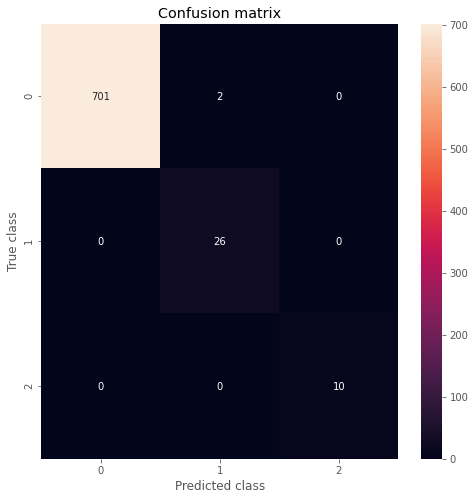

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       703
           1       0.93      1.00      0.96        26
           2       1.00      1.00      1.00        10

    accuracy                           1.00       739
   macro avg       0.98      1.00      0.99       739
weighted avg       1.00      1.00      1.00       739



In [197]:
LABELS = [0,1,2]
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### **Random Forest**

In [199]:
from sklearn.ensemble import RandomForestClassifier
# otro modelo, variando hiperparámetros
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=2, max_depth=6,
                               oob_score=True, random_state=50)
# a entrenar
model.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=50, verbose=2,
                       warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


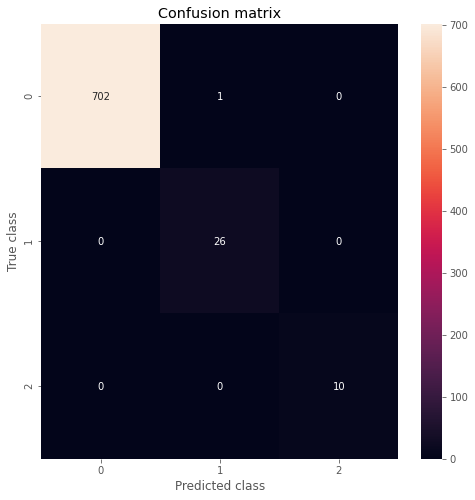

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       703
           1       0.96      1.00      0.98        26
           2       1.00      1.00      1.00        10

    accuracy                           1.00       739
   macro avg       0.99      1.00      0.99       739
weighted avg       1.00      1.00      1.00       739



In [200]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)